In [108]:
import sys
import os
import json
import torch
from torch.utils.data import DataLoader
from collections import OrderedDict
from model import MolVAE
from textdata import textdata
from utils import *
from lorentz_model import *
from clustering import *

import numpy as np
import pandas as pd
import random
from rdkit import Chem
from rdkit import rdBase
rdBase.DisableLog('rdApp.error') #disable RDKit warning messages
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import umap

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy import spatial

In [2]:
def dist_z(manifold_type, z1, z2):
    if manifold_type == 'Euclidean':
        d2 = torch.dist(z1, z2)
    elif manifold_type == 'Lorentz' :
        d2 = arccosh(-lorentz_product(z1,z2))
    return d2

In [3]:
# return a list of defined models
def load_model(exp_checkpoints):
    configs_lst = []
    mdl_lst = []
    for m in exp_checkpoints:
        exp_dir = './experiments/SMILES/'
        exp_name = m[0]
        checkpoint = m[1]
        config_path = os.path.join(exp_dir + exp_name, 'configs.json')
        checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)
        
        # load configurations
        with open(config_path, 'r') as fp:
            configs = json.load(fp)
        fp.close()
        
        datasets = OrderedDict()
        splits = ['train', 'valid', 'test']
        for split in splits:
            datasets[split] = textdata(data_dir=configs['data_dir'], exp_dir=os.path.join(configs['checkpoint_dir'], configs['experiment_name']), split=split, vocab_file=configs['vocab_file'],
                                       max_sequence_length=configs['max_sequence_length'])
        #build model
        model = MolVAE(
            vocab_size=datasets['train'].vocab_size,
            embedding_size=datasets['train'].vocab_size,
            hidden_size=configs['hidden_size'],
            latent_size=configs['latent_size'],
            manifold_type=configs['manifold_type'],
            rnn_type=configs['rnn_type'],
            bidirectional=configs['bidirectional'],
            num_layers=configs['num_layers'],
            word_dropout_rate=configs['word_dropout_rate'],
            embedding_dropout_rate=configs['embedding_dropout_rate'],
            one_hot_rep=configs['one_hot_rep'],
            max_sequence_length=configs['max_sequence_length'],
            sos_idx=datasets['train'].sos_idx,
            eos_idx=datasets['train'].eos_idx,
            pad_idx=datasets['train'].pad_idx,
            unk_idx=datasets['train'].unk_idx,
            prior_var=configs['prior_var']
        )
        # load checkpoint
        model.load_state_dict(torch.load(checkpoint_path))
        if torch.cuda.is_available():
            model = model.cuda()
        model.eval()
        
        configs_lst.append(configs)
        mdl_lst.append(model)
    return configs_lst, mdl_lst

In [4]:
def beam_search_conditional_mean(configs_lst, mdl_lst, smile_x):
    img_lst = []
    n = len(mdl_lst)
    for i in range(n):
        configs = configs_lst[i]
        model = mdl_lst[i]
        mean, _ = smiles2mean(configs, smile_x, model)
        z, samples_idx, smiles_lst = latent2smiles(configs, model, mean, nsamples=15, sampling_mode='beam')
        smiles_grid = [smile_x] + smiles_lst

        mol_grid=[]
        for smi in smiles_grid:
            try:
                mol_grid.append(Chem.MolFromSmiles(smi))
            except:
                pass

        img=Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=smiles_grid)
        img_lst.append(img)
    return img_lst

In [5]:
def greedy_posterior_samples(configs_lst, mdl_lst, smile_x, nsamples):
    img_lst = []
    n = len(mdl_lst)

    for i in range(n):
        configs = configs_lst[i]
        model = mdl_lst[i]
        mean, logv = smiles2mean(configs, smile_x, model)
        std = torch.exp(0.5 * logv)
        if configs['manifold_type'] == 'Euclidean':
            z = to_cuda_var(torch.randn([nsamples, configs['latent_size']]))
            z = z * std + mean
            vt = None
            u = None
        elif configs['manifold_type'] == 'Lorentz':
            vt, u, z = lorentz_sampling(mean.repeat(nsamples,1), logv.repeat(nsamples,1))    
        samples_idx, z = model.inference(n=z.shape[0], sampling_mode='greedy', z=z)
        smiles_x_samples = idx2smiles(configs, samples_idx)
        smiles_x_samples_lst = [[smile_x, 0.0]]
        for i in range(len(smiles_x_samples)):
            d2 = dist_z(configs['manifold_type'], mean.view(1,-1), z[i,:].view(1,-1))
            smiles_x_samples_lst.append([smiles_x_samples[i],d2.item()])

        # sort by distance
        smiles_x_samples_df = pd.DataFrame(smiles_x_samples_lst, columns=['SMILES','DISTANCE'])
        smiles_x_samples_sorted = smiles_x_samples_df.sort_values(by=['DISTANCE']).SMILES.tolist()
        smiles_x_distance_sorted = smiles_x_samples_df.sort_values(by=['DISTANCE']).DISTANCE.tolist()

        # create legend
        legend_lst = []
        for l in range(len(smiles_x_samples_sorted)):
            legend = smiles_x_samples_sorted[l] + ' (' + str(round(smiles_x_distance_sorted[l],2)) + ')'
            legend_lst.append(legend)
            
        mol_grid=[]
        smiles_grid = smiles_x_samples_sorted
        for smi in smiles_grid:
            try:
                mol_grid.append(Chem.MolFromSmiles(smi))
            except:
                pass

        img = Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=5,subImgSize=(400,400), legends=legend_lst)
        img_lst.append(img)
    return img_lst

In [6]:
# beam search posterior samples
def greedy_posterior_samples2(configs_lst, mdl_lst, smile_x, nsamples):
    img_lst = []
    n = len(mdl_lst)

    for i in range(n):
        configs = configs_lst[i]
        model = mdl_lst[i]
        mean, logv = smiles2mean(configs, smile_x, model)
        std = torch.exp(0.5 * logv)
        if configs['manifold_type'] == 'Euclidean':
            z = to_cuda_var(torch.randn([nsamples, configs['latent_size']]))
            z = z * std + mean
            vt = None
            u = None
        elif configs['manifold_type'] == 'Lorentz':
            vt, u, z = lorentz_sampling(mean.repeat(nsamples,1), logv.repeat(nsamples,1))    
        #samples_idx, z = model.inference(n=z.shape[0], sampling_mode='greedy', z=z)
        #smiles_x_samples = idx2smiles(configs, samples_idx) 
        smiles_set_lst = []
        for i in range(nsamples):
            zi = z[i,:]
            _, _, smiles_lst = latent2smiles(configs, model, zi, nsamples=5, sampling_mode='beam')    
            smiles_set_lst.append(smiles_lst)
        
        smiles_x_samples = list(set(smiles_set_lst))
            
        mol_grid=[]
        k = 0
        for smi in smiles_grid:
            try:
                mol_grid.append(Chem.MolFromSmiles(smi))
            except:
                pass
            if k > 24:
                break

        img = Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=5,subImgSize=(400,400), legends=smiles_x_samples_sorted)
        img_lst.append(img)
    return img_lst

In [7]:
def posterior_samples_quality(configs_lst, mdl_lst, dataset):    
    n = len(mdl_lst)
    smi_sample_df_lst = []
    for i in range(n):
        configs = configs_lst[i]
        model = mdl_lst[i]
        if dataset == 'test':
            smiles_test = create_smiles_lst('./experiments/SMILES' + '/' + configs['experiment_name'], 'smiles_test.smi')
            input_smiles = random.sample(smiles_test, 1500)
        elif dataset == 'fda':
            input_smiles = create_smiles_lst('./data', 'all_drugs_only.smi')
        smiles_sample_lst = []
        for smi in input_smiles:
            mean, logv = smiles2mean(configs, smi, model)
            samples_idx, z = model.inference(n=mean.shape[0], sampling_mode='greedy', z=mean)
            smi_sample = idx2smiles(configs, samples_idx)[0]
            # calculate target molecule metrics
            mol_t = smiles_to_mol(smi)
            fp_t = FingerprintMols.FingerprintMol(mol_t)
            # calculate sampled molecule metrics
            if smiles_to_mol(smi_sample) is not None:
                mol_s = smiles_to_mol(smi_sample)
                validty = 1
                fp_s = FingerprintMols.FingerprintMol(mol_s)
                tanimoto = DataStructs.FingerprintSimilarity(fp_t,fp_s)
            else:
                validty = 0
                fp_s = None
                tanimoto = 0
            smiles_sample_lst.append([smi, smi_sample, validty, smi==smi_sample, tanimoto, mean])
        smi_sample_df = pd.DataFrame(smiles_sample_lst,columns=['SMILES_T', 'SMILES_S', 'VALIDITY', 'EXACT', 'TANIMOTO', 'SMILES_Z'])
        smi_sample_df_lst.append(smi_sample_df)
    return smi_sample_df_lst

In [8]:
def centroids_tensor(configs):
    centroids_lst = []
    for c in range(configs['num_centroids']):
        centroids_textdata = configs['centroids']
        centroids_lst.append(centroids_textdata[c]['inputs'])
    return to_cuda_var(torch.from_numpy(np.stack(centroids_lst)))

def vamp_samples(configs, model, nsamples):
    idx = np.random.randint(configs['num_centroids'], size=nsamples)
    centroids = centroids_tensor(configs)[idx,:]
    inputs = centroids
    lens = (inputs != 0).sum(dim=1) - 1
    _, z_p_mean, z_p_logvar, _, _, _ = model(inputs, lens) # k * dim(z)
    z_p_std = torch.exp(0.5 * z_p_logvar)
    if configs['manifold_type'] == 'Euclidean':
        z = to_cuda_var(torch.randn([nsamples, configs['latent_size']]))
        z = z * z_p_std + z_p_mean
        vt = None
        u = None
    elif configs['manifold_type'] == 'Lorentz':
        vt, u, z = lorentz_sampling(z_p_mean.repeat(1,1), z_p_logvar.repeat(1,1))     
    return centroids, z

def greedy_prior_samples(configs_lst, mdl_lst, nsamples):
    img_lst = []
    n = len(mdl_lst)
    for i in range(n):
        configs = configs_lst[i]
        model = mdl_lst[i]
        if configs['prior_type'] == 'Standard':
            samples_idx, z = model.inference(n=nsamples, sampling_mode='greedy', z=None)
        elif configs['prior_type'] == 'VampPrior':
            centrioids, z = vamp_samples(configs, model, nsamples)
            samples_idx, _ = model.inference(n=z.shape[0], sampling_mode='greedy', z=z)
        prior_smiles_sample = idx2smiles(configs, samples_idx)
        smiles_grid = prior_smiles_sample
        mol_grid=[]
        for smi in smiles_grid:
            try:
                mol_grid.append(Chem.MolFromSmiles(smi))
            except:
                pass
        img = Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=smiles_grid)
        img_lst.append(img)
    return img_lst

In [9]:
def prior_samples_quality(configs_lst, mdl_lst, nsamples):    
    n = len(mdl_lst)
    smi_freq_df_lst = []
    for i in range(n):
        configs = configs_lst[i]
        model = mdl_lst[i]
        
        if configs['prior_type'] == 'Standard':
            samples_idx, z = model.inference(n=nsamples, sampling_mode='greedy', z=None)
        elif configs['prior_type'] == 'VampPrior':
            centrioids, z = vamp_samples(configs, model, nsamples)
            samples_idx, _ = model.inference(n=z.shape[0], sampling_mode='greedy', z=z)           
        input_smiles = idx2smiles(configs, samples_idx)
        smi_freq_df = eval_prior_samples(configs, input_smiles)
        smi_freq_df_lst.append(smi_freq_df)
    return smi_freq_df_lst

In [10]:
# prepare FDA drugs dataset
def fda_dataloader(configs):
    fda_data = textdata(data_dir=configs['data_dir'], exp_dir='./data', split=None, vocab_file=configs['vocab_file'],
                        max_sequence_length=configs['max_sequence_length'], filename='all_drugs_only.smi')

    fda_loader = DataLoader(
        dataset=fda_data,
        batch_size=len(fda_data.data),
        shuffle=False,
        pin_memory=torch.cuda.is_available()
    )
    for iteration, fda_batch in enumerate(fda_loader):
        fda_batch_size = fda_batch['inputs'].size(0)
        for k, v in fda_batch.items():
            if torch.is_tensor(v):
                fda_batch[k] = to_cuda_var(v)
    return fda_batch

In [11]:
def plot_exemplar_smiles(fda_batch, configs_lst, mdl_lst):
    #seed = 0
    #torch.manual_seed(seed)
    img_lst = []
    exemplar_lst = []
    n = len(mdl_lst)
    for i in range(n):
        configs = configs_lst[i]
        model = mdl_lst[i]
        if configs['prior_type'] == 'VampPrior':
            logp_f, mean_f, logv_f, z_f, vt_f, u_f = model(fda_batch['inputs'], fda_batch['len'])
            x_input = fda_batch['inputs'].data.cpu().numpy()
            z_input = z_f.data.cpu().numpy()
            centroids = clustering_z(x_input, z_input, configs['manifold_type'], configs['num_centroids'])
            smiles_grid = idx2smiles(configs, centroids[:,1:])
            exemplar_lst.append(smiles_grid)
            mol_grid=[]
            for smi in smiles_grid:
                try:
                    mol_grid.append(Chem.MolFromSmiles(smi))
                except:
                    pass
            img = Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=smiles_grid)
            img_lst.append(img)
    return exemplar_lst, img_lst

In [12]:
def drugs_mu_dict_creator(configs_lst, mdl_lst):
    # compute the posterior means for FDA drugs
    fda_drugs = 'all_drugs.smi'
    fda_drugs_path = os.path.join('./data/', fda_drugs)
    
    drugs_mu_dict_lst = []
    n = len(mdl_lst)
    for i in range(n):
        configs = configs_lst[i]
        model = mdl_lst[i]
        w2i, i2w = idx2word(configs['data_dir'], configs['vocab_file'])
        
        drugs_dict = {}
        with open(fda_drugs_path, 'r') as file:
            for seq in file.readlines():
                if seq != '\n':
                    line = seq.split(" ")
                    drugs_dict[lower(line[1])] = line[0]
        file.close()

        drugs_mu_dict = {}
        for key in drugs_dict.keys():
            smile_1st = drugs_dict[key]
            input_sequence = [w2i['<sos>']]
            for i in smile_1st:
                try:
                    input_sequence.append(w2i[i])
                except:
                    input_sequence.append(w2i['<unk>'])
            input_sequence.append(w2i['<eos>'])
            input_sequence = input_sequence + [0] * (configs['max_sequence_length'] - len(input_sequence) - 1)
            input_sequence = np.asarray(input_sequence)
            input_sequence = torch.from_numpy(input_sequence).unsqueeze(0)
            sequence_length = torch.tensor([len(smile_1st) + 1])
            _, mean, logv, _, _, _ = model.forward(input_sequence, sequence_length)

            samples_idx, z = model.inference(n=1, sampling_mode='greedy', z=mean)
            for i in range(1):
                smiles = []
                for j in range(configs['max_sequence_length']):
                    if samples_idx[i, j] == w2i['<eos>']:
                        break
                    smiles.append(i2w[samples_idx[i, j].item()])
                smiles = "".join(smiles)

            drugs_mu_dict[key] = [smile_1st, smiles, mean.cpu().detach().numpy()]
        drugs_mu_dict_lst.append(drugs_mu_dict)
    return drugs_mu_dict_lst

In [60]:
def drug_hier_path(configs_lst, mdl_lst, drugs_mu_dict_lst):
    n = len(mdl_lst)
    fda_drugs_culster_df_lst = []
    for i in range(n):
        configs = configs_lst[i]
        modle = mdl_lst[i]
        drugs_mu_dict = drugs_mu_dict_lst[i]
        
        # Combine drugs latent representations into a matrix
        drug_lst=[]
        smile_lst=[]
        gen_smile_lst=[]
        latent_lst=[]
        label_lst=[]
        for key in drugs_mu_dict.keys():
            h = drugs_mu_dict[key][2]
            latent_lst.append(h)
            drug_lst.append(key)
            smile_lst.append(drugs_mu_dict[key][0])
            gen_smile_lst.append(drugs_mu_dict[key][1])
            label_lst.append(key+'<br>'+drugs_mu_dict[key][0]+'<br>'+drugs_mu_dict[key][1])
        latent_reps = np.asarray(latent_lst).squeeze()
        nsamples, _ = latent_reps.shape
        dist_condensed = pairwise_dist(configs['manifold_type'],latent_reps)
        dist_condensed[np.isnan(dist_condensed)] = 0
        dist_mtrx = spatial.distance.squareform(dist_condensed)
        
        # compute linkage output
        linkage_output = linkage(dist_condensed, 'complete')
    
        # decoding linkage output
        fda_drugs_names = list(drugs_mu_dict.keys())
        niterations, _ = linkage_output.shape
        linkage_decoded = {}
        for i in range(niterations):
            iteration = linkage_output[i]

            i1 = int(iteration[0])
            i2 = int(iteration[1])

            if i1 < nsamples:
                c1 = [fda_drugs_names[i1]]
            else:
                c1 = linkage_decoded[i1][2]
            if i2 < nsamples:
                c2 = [fda_drugs_names[i2]]
            else:
                c2 = linkage_decoded[i2][2]

            c = c1 + c2

            d = iteration[2]

            ns = iteration[3]
            assert ns == len(c)

            linkage_decoded[nsamples+i] = [c1, c2, c, d, ns]

        fda_drugs_culster_df = pd.DataFrame.from_dict(linkage_decoded, orient='index').reset_index()
        fda_drugs_culster_df.columns = ['index','cluster_1','cluster_2', 'cluster', 'distance', 'num_samples']
        
        fda_drugs_culster_df_lst.append(fda_drugs_culster_df)
    return fda_drugs_culster_df_lst

In [13]:
def lower(x):
    return x.lower()

In [14]:
# Load ATC data
df_act = pd.read_csv('./data/ATC_LOOKUP.csv')

# Load FDA drugs
fda_drugs = 'all_drugs.smi'
fda_drugs_path = os.path.join('./data/', fda_drugs)
drugs_dict = {}
with open(fda_drugs_path, 'r') as file:
    for seq in file.readlines():
        if seq != '\n':
            line = seq.split(" ")
            drugs_dict[lower(line[1])] = line[0]
file.close()
fda_df = pd.DataFrame.from_dict(drugs_dict, orient='index').reset_index()
fda_df.columns = ['active_ingredient','smile_x']

# substance in both ATC and FDA
atc_fda_inner = pd.merge(df_act, fda_df, how='inner', left_on='ATC_LVL5', right_on='active_ingredient')

In [15]:
len(atc_fda_inner['active_ingredient'].unique())

1055

* 1385-1055 = 330 substances in FDA drugs but not in ATC
* 4239 - 1055 = 3184 ATC level 5 items not in FDA drugs dataset

# Samping from posterior ~q(z|x)

In [16]:
# define experiments and checkpoints
exp_checkpoints = [('basic_zinc_fda_euc','checkpoint_epoch100.model'), 
                   ('basic_zinc_fda_lor','checkpoint_epoch100.model')]
# load model objects into a list
configs_lst, mdl_lst = load_model(exp_checkpoints)

## Beam search (width = 15) at the conditional mean

In [17]:
# set the input SMILES
smile_x = 'OCCN1CCN(CC/C=C2/c3ccccc3Sc3ccc(Cl)cc32)CC1'
mu_img_lst = beam_search_conditional_mean(configs_lst, mdl_lst, smile_x)

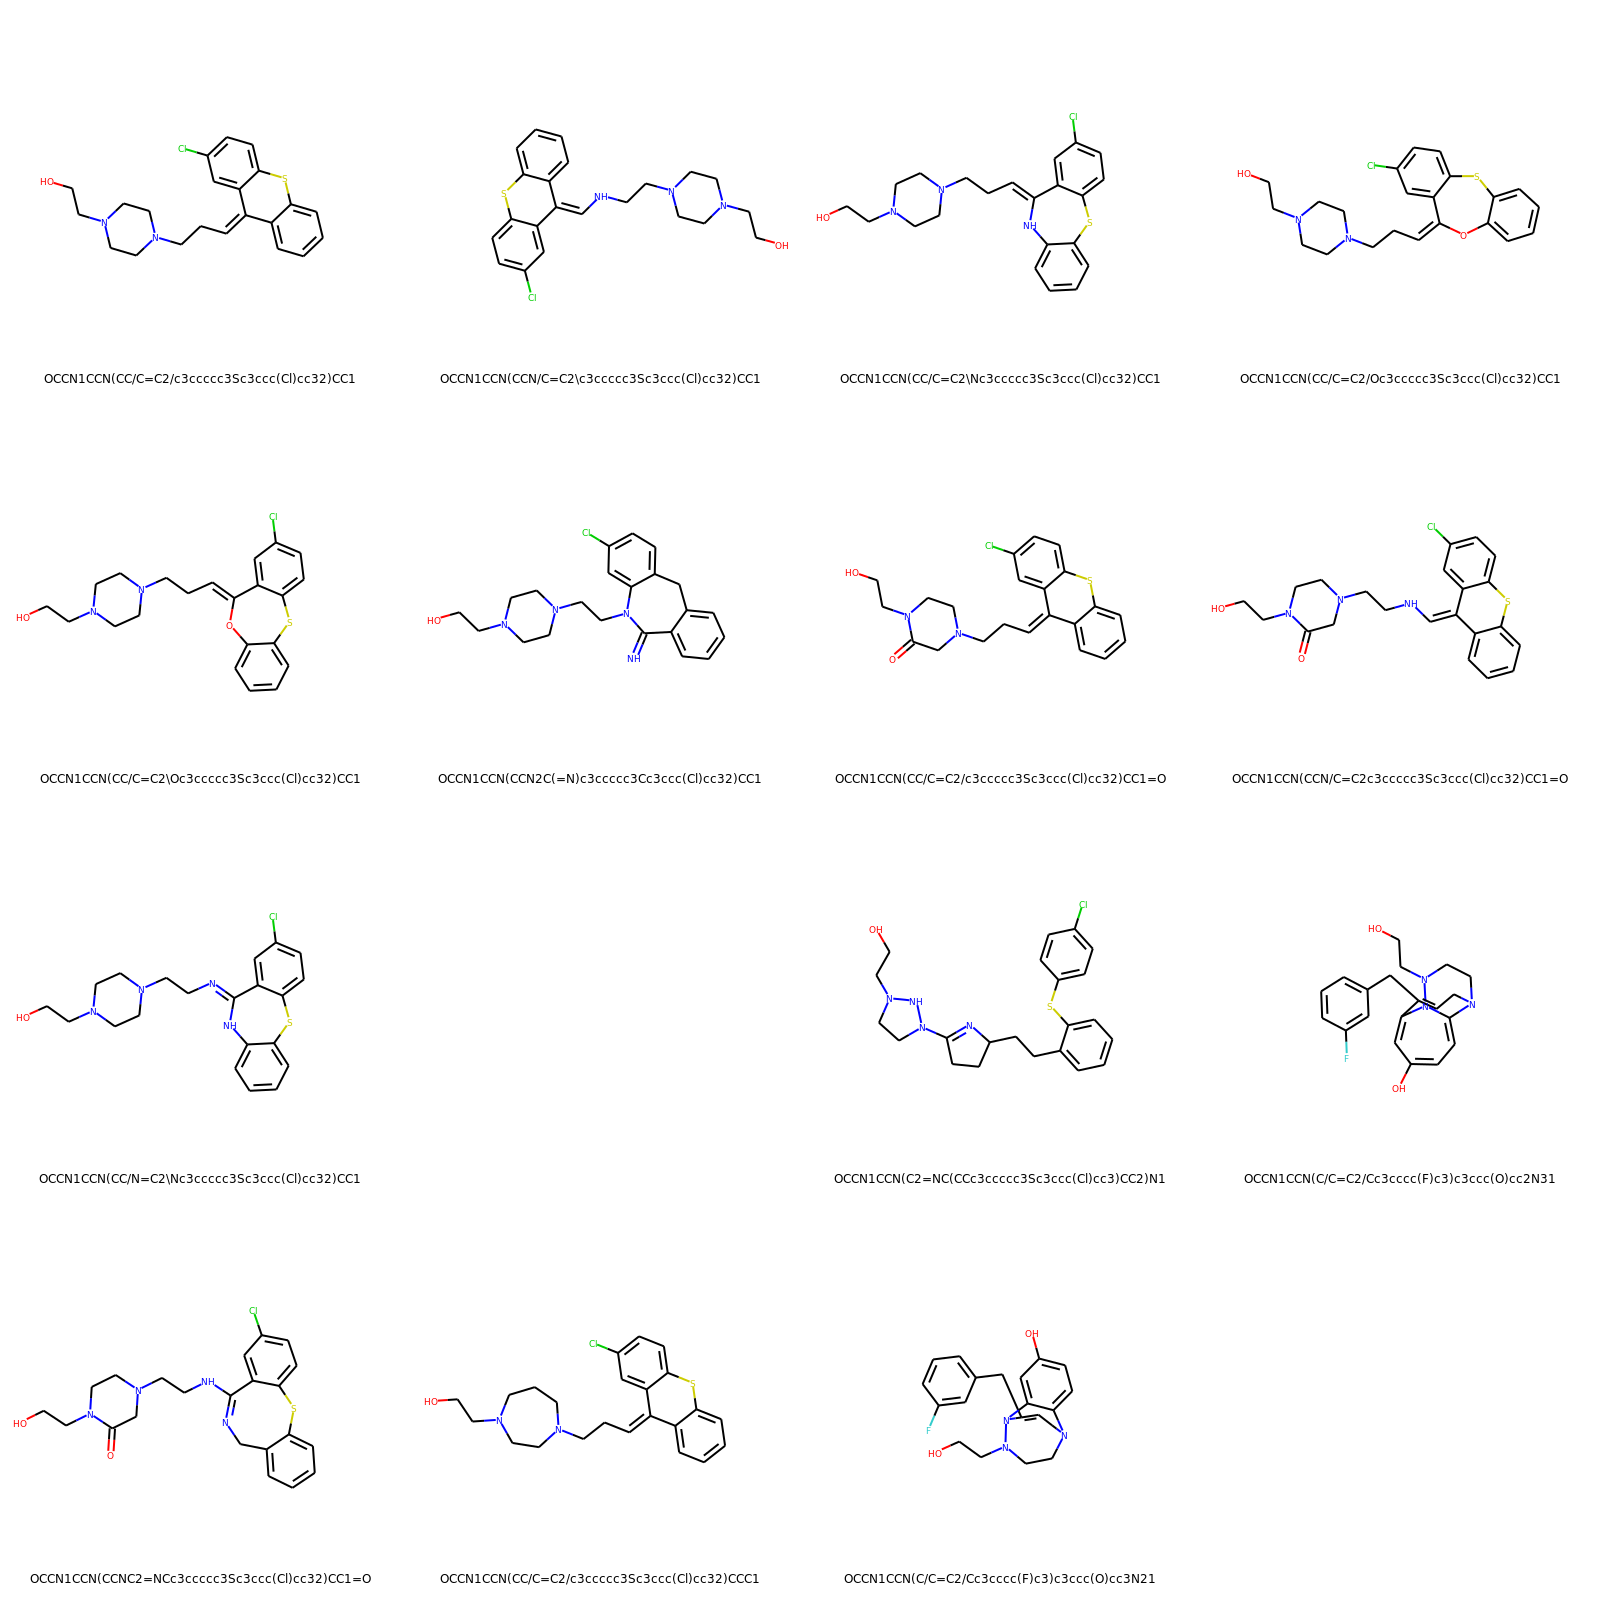

In [18]:
mu_img_lst[0]

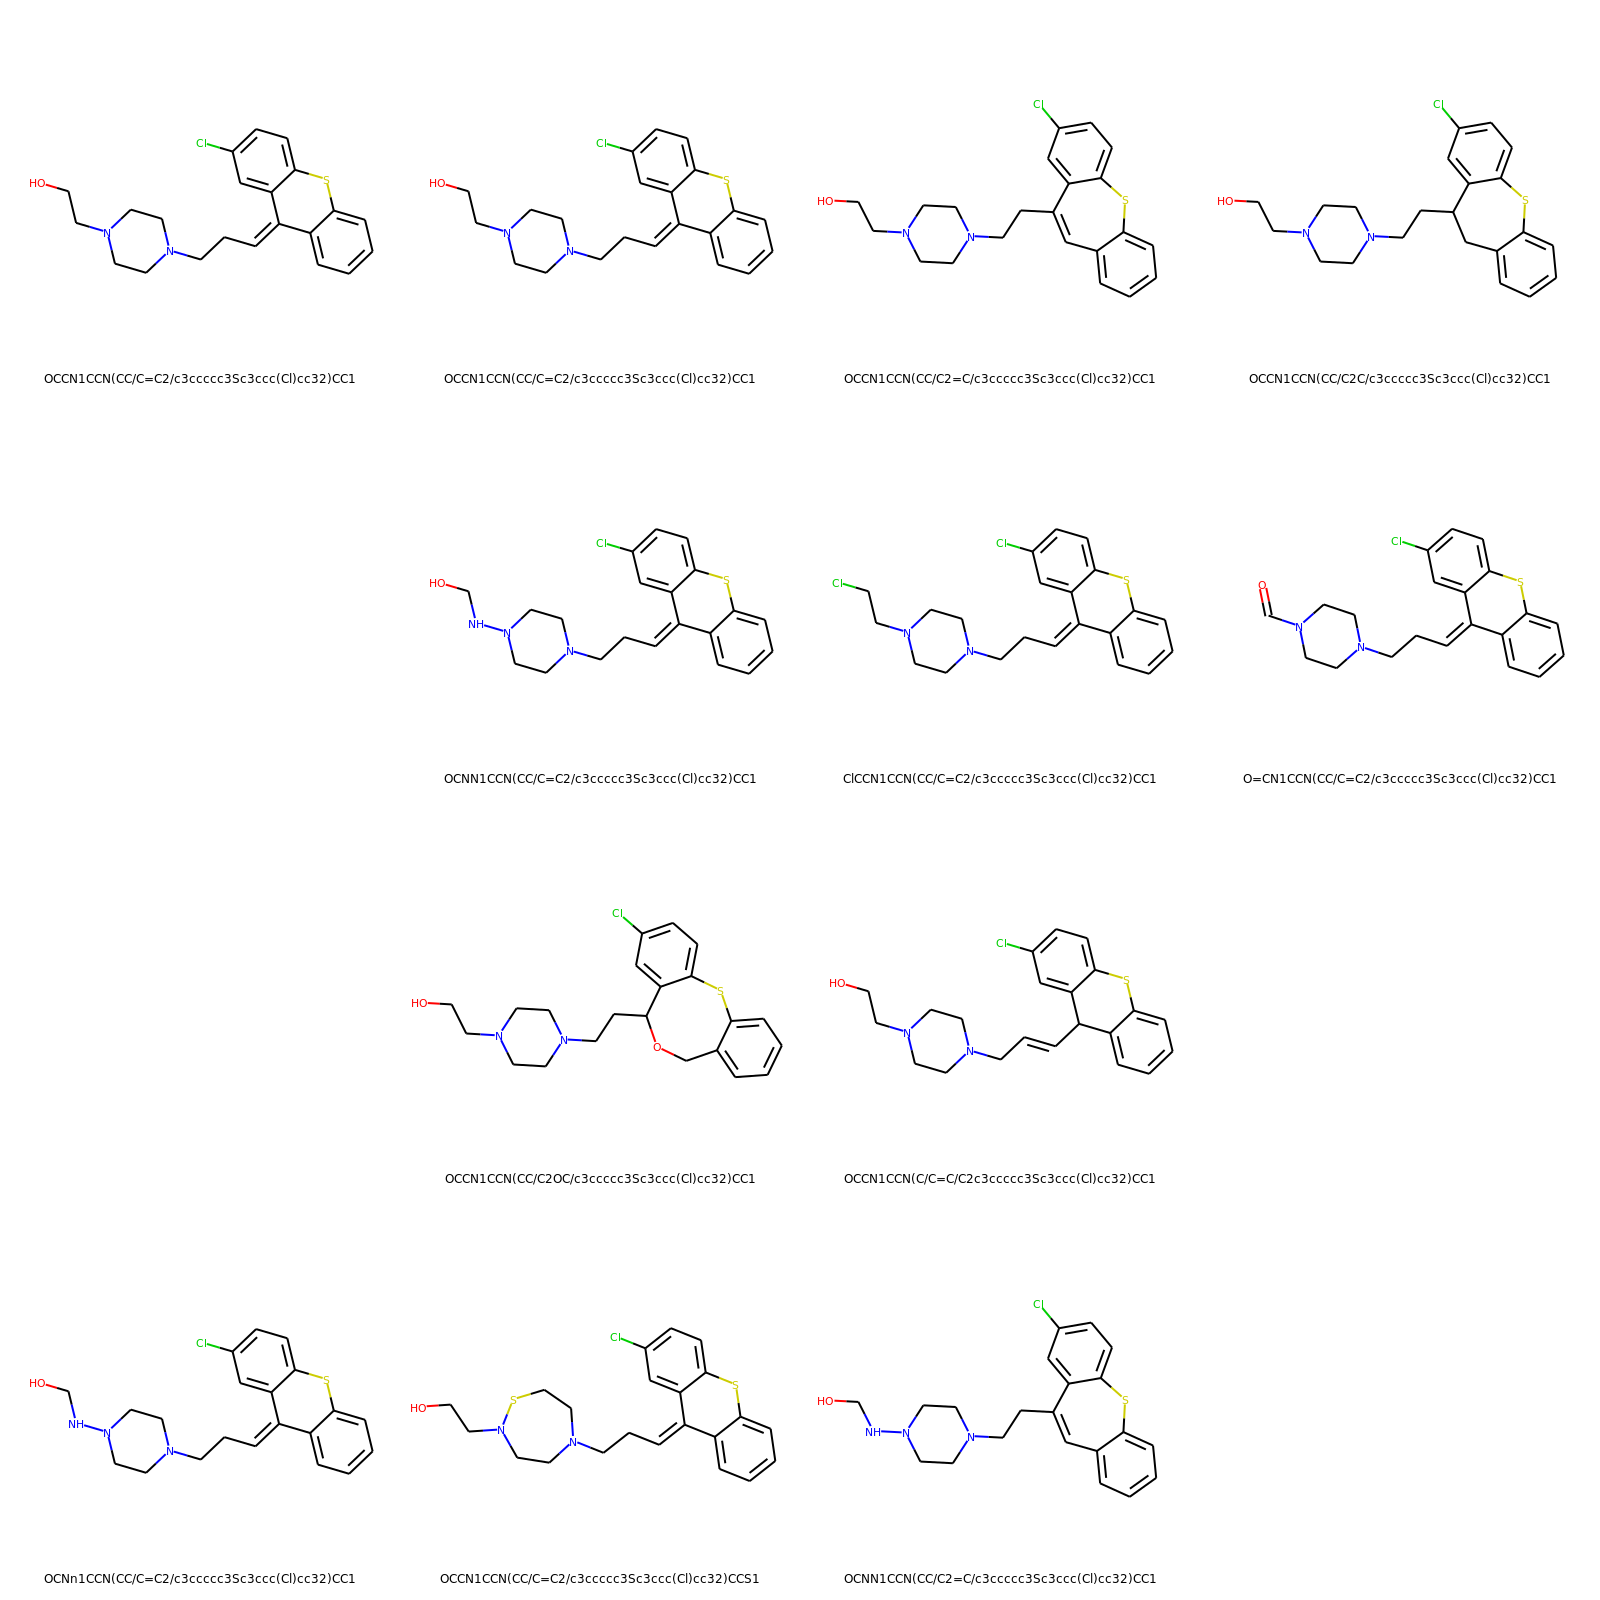

In [19]:
mu_img_lst[1]

## Greedy search at latent points (z) sampled from conditional posterior distribution 

In [20]:
nsamples = 24
z_q_img_lst = greedy_posterior_samples(configs_lst, mdl_lst, smile_x, nsamples)

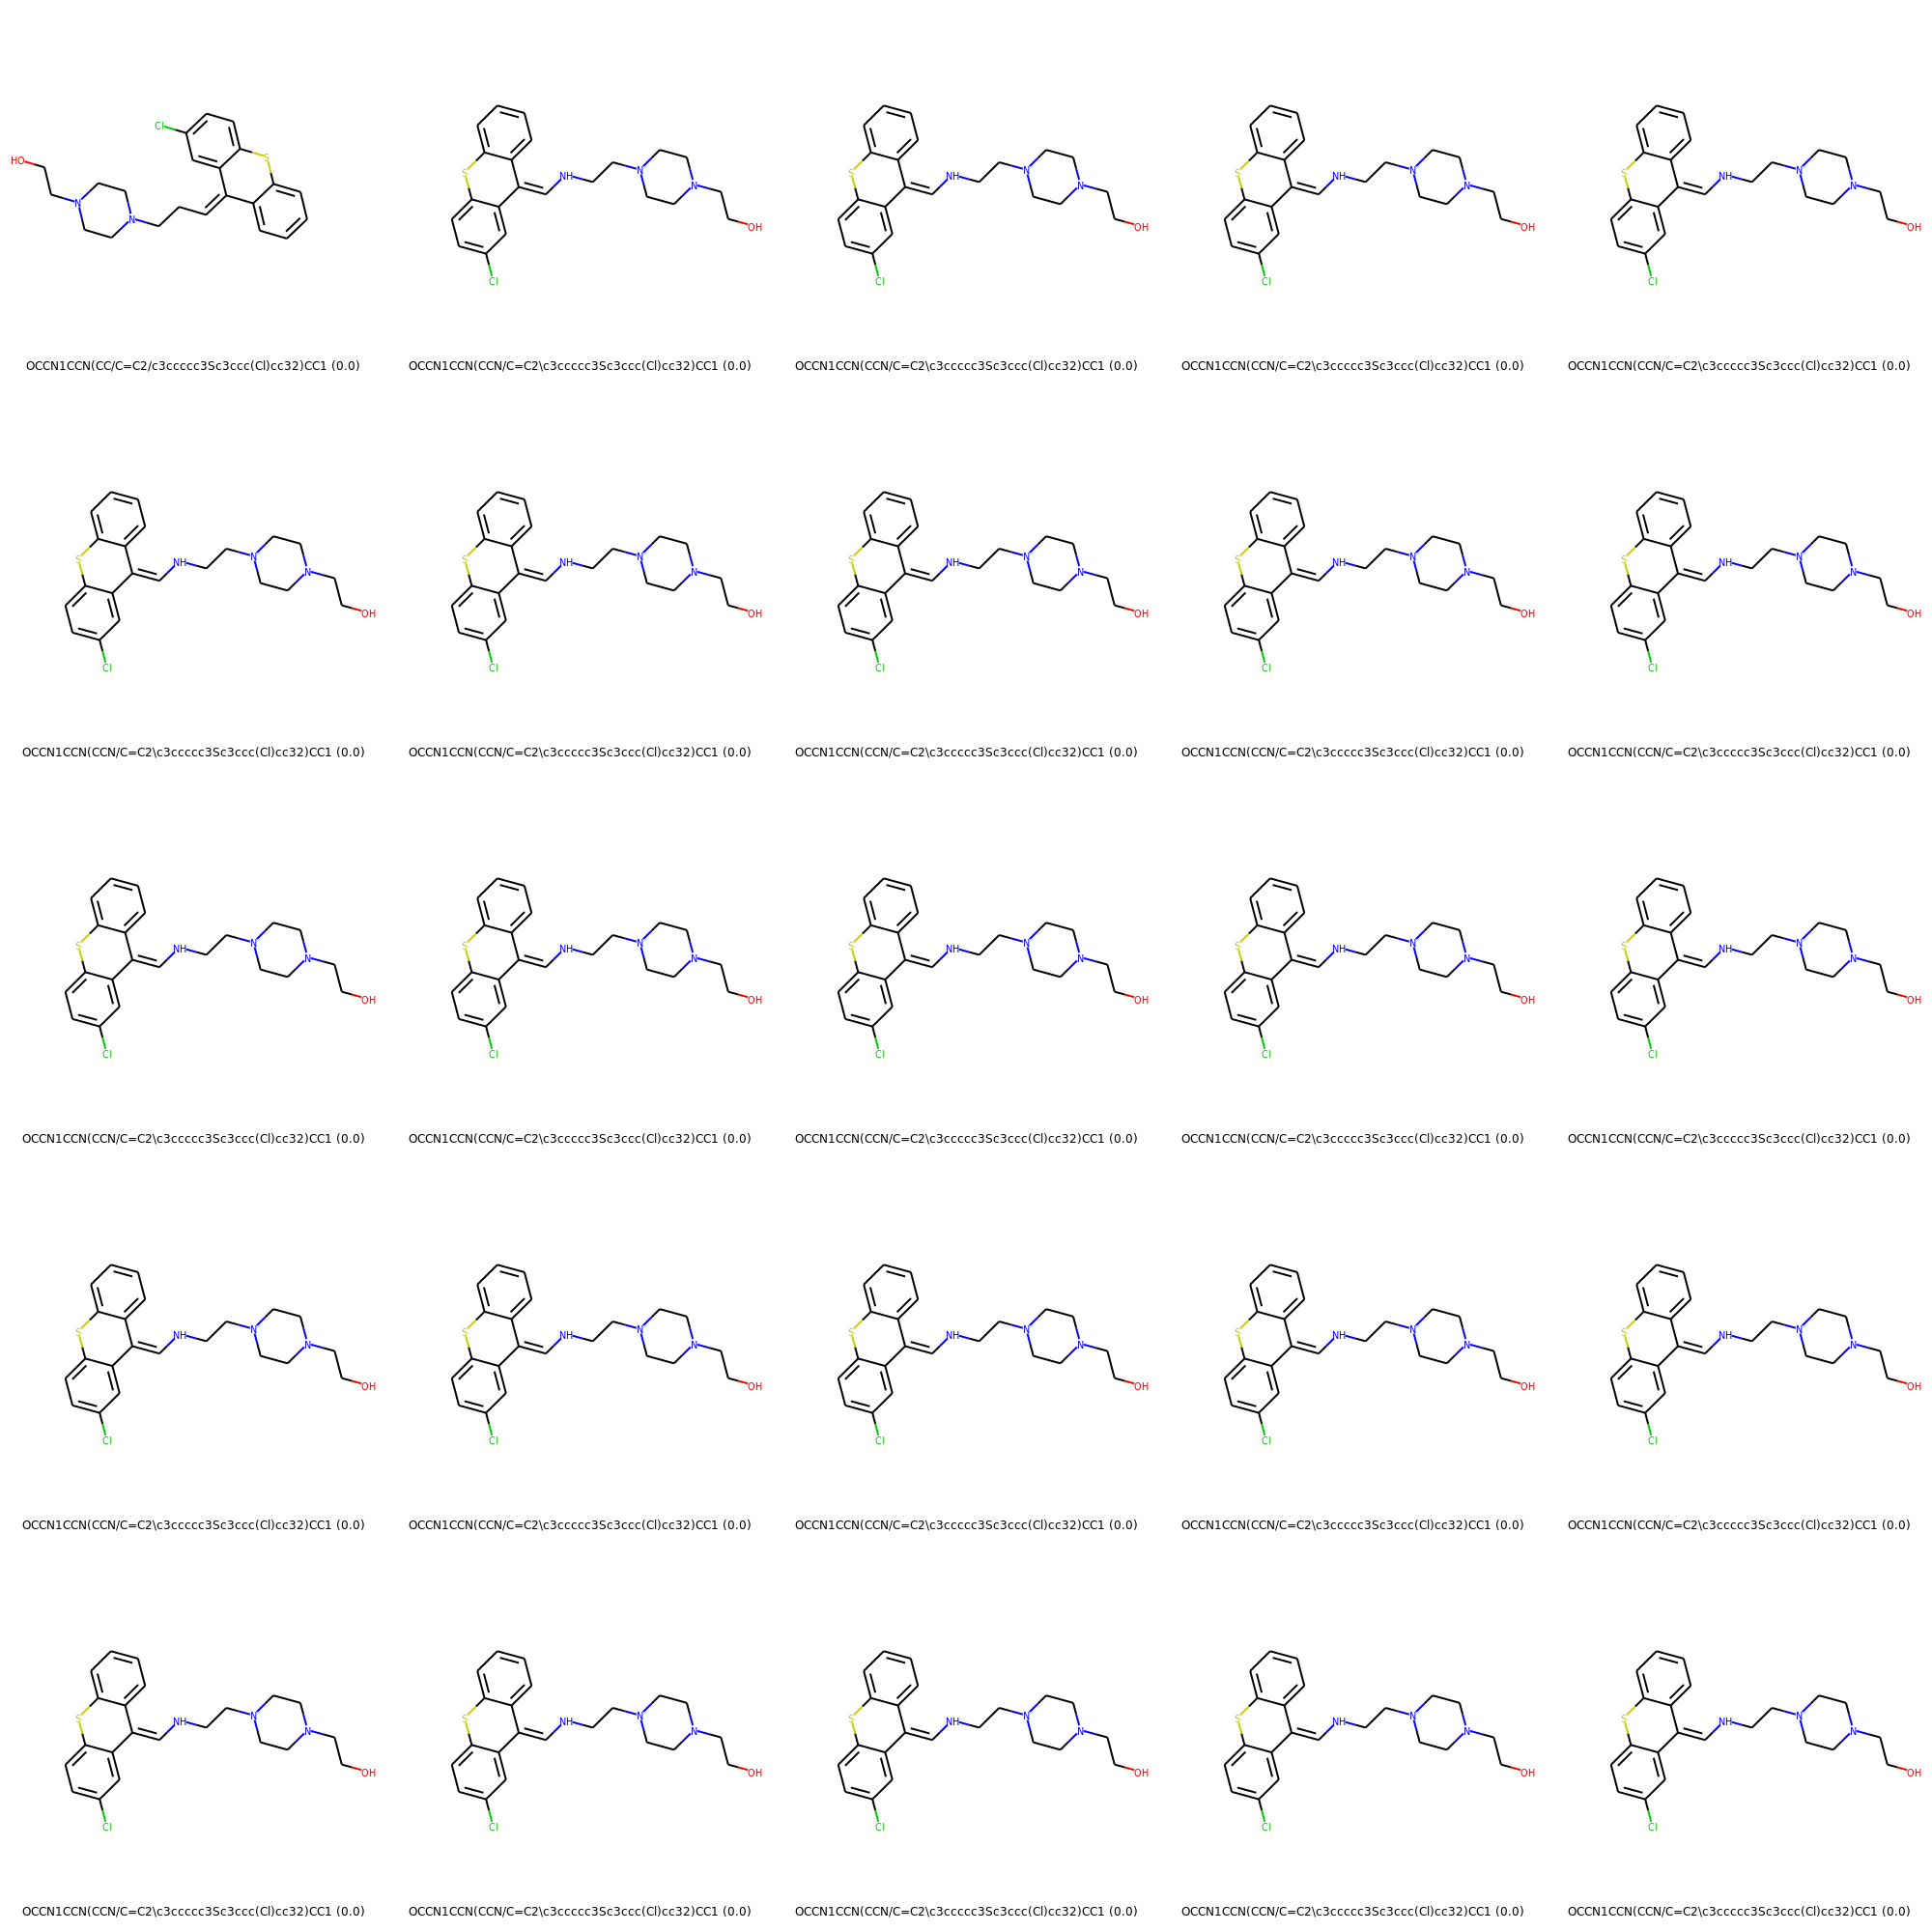

In [21]:
z_q_img_lst[0]

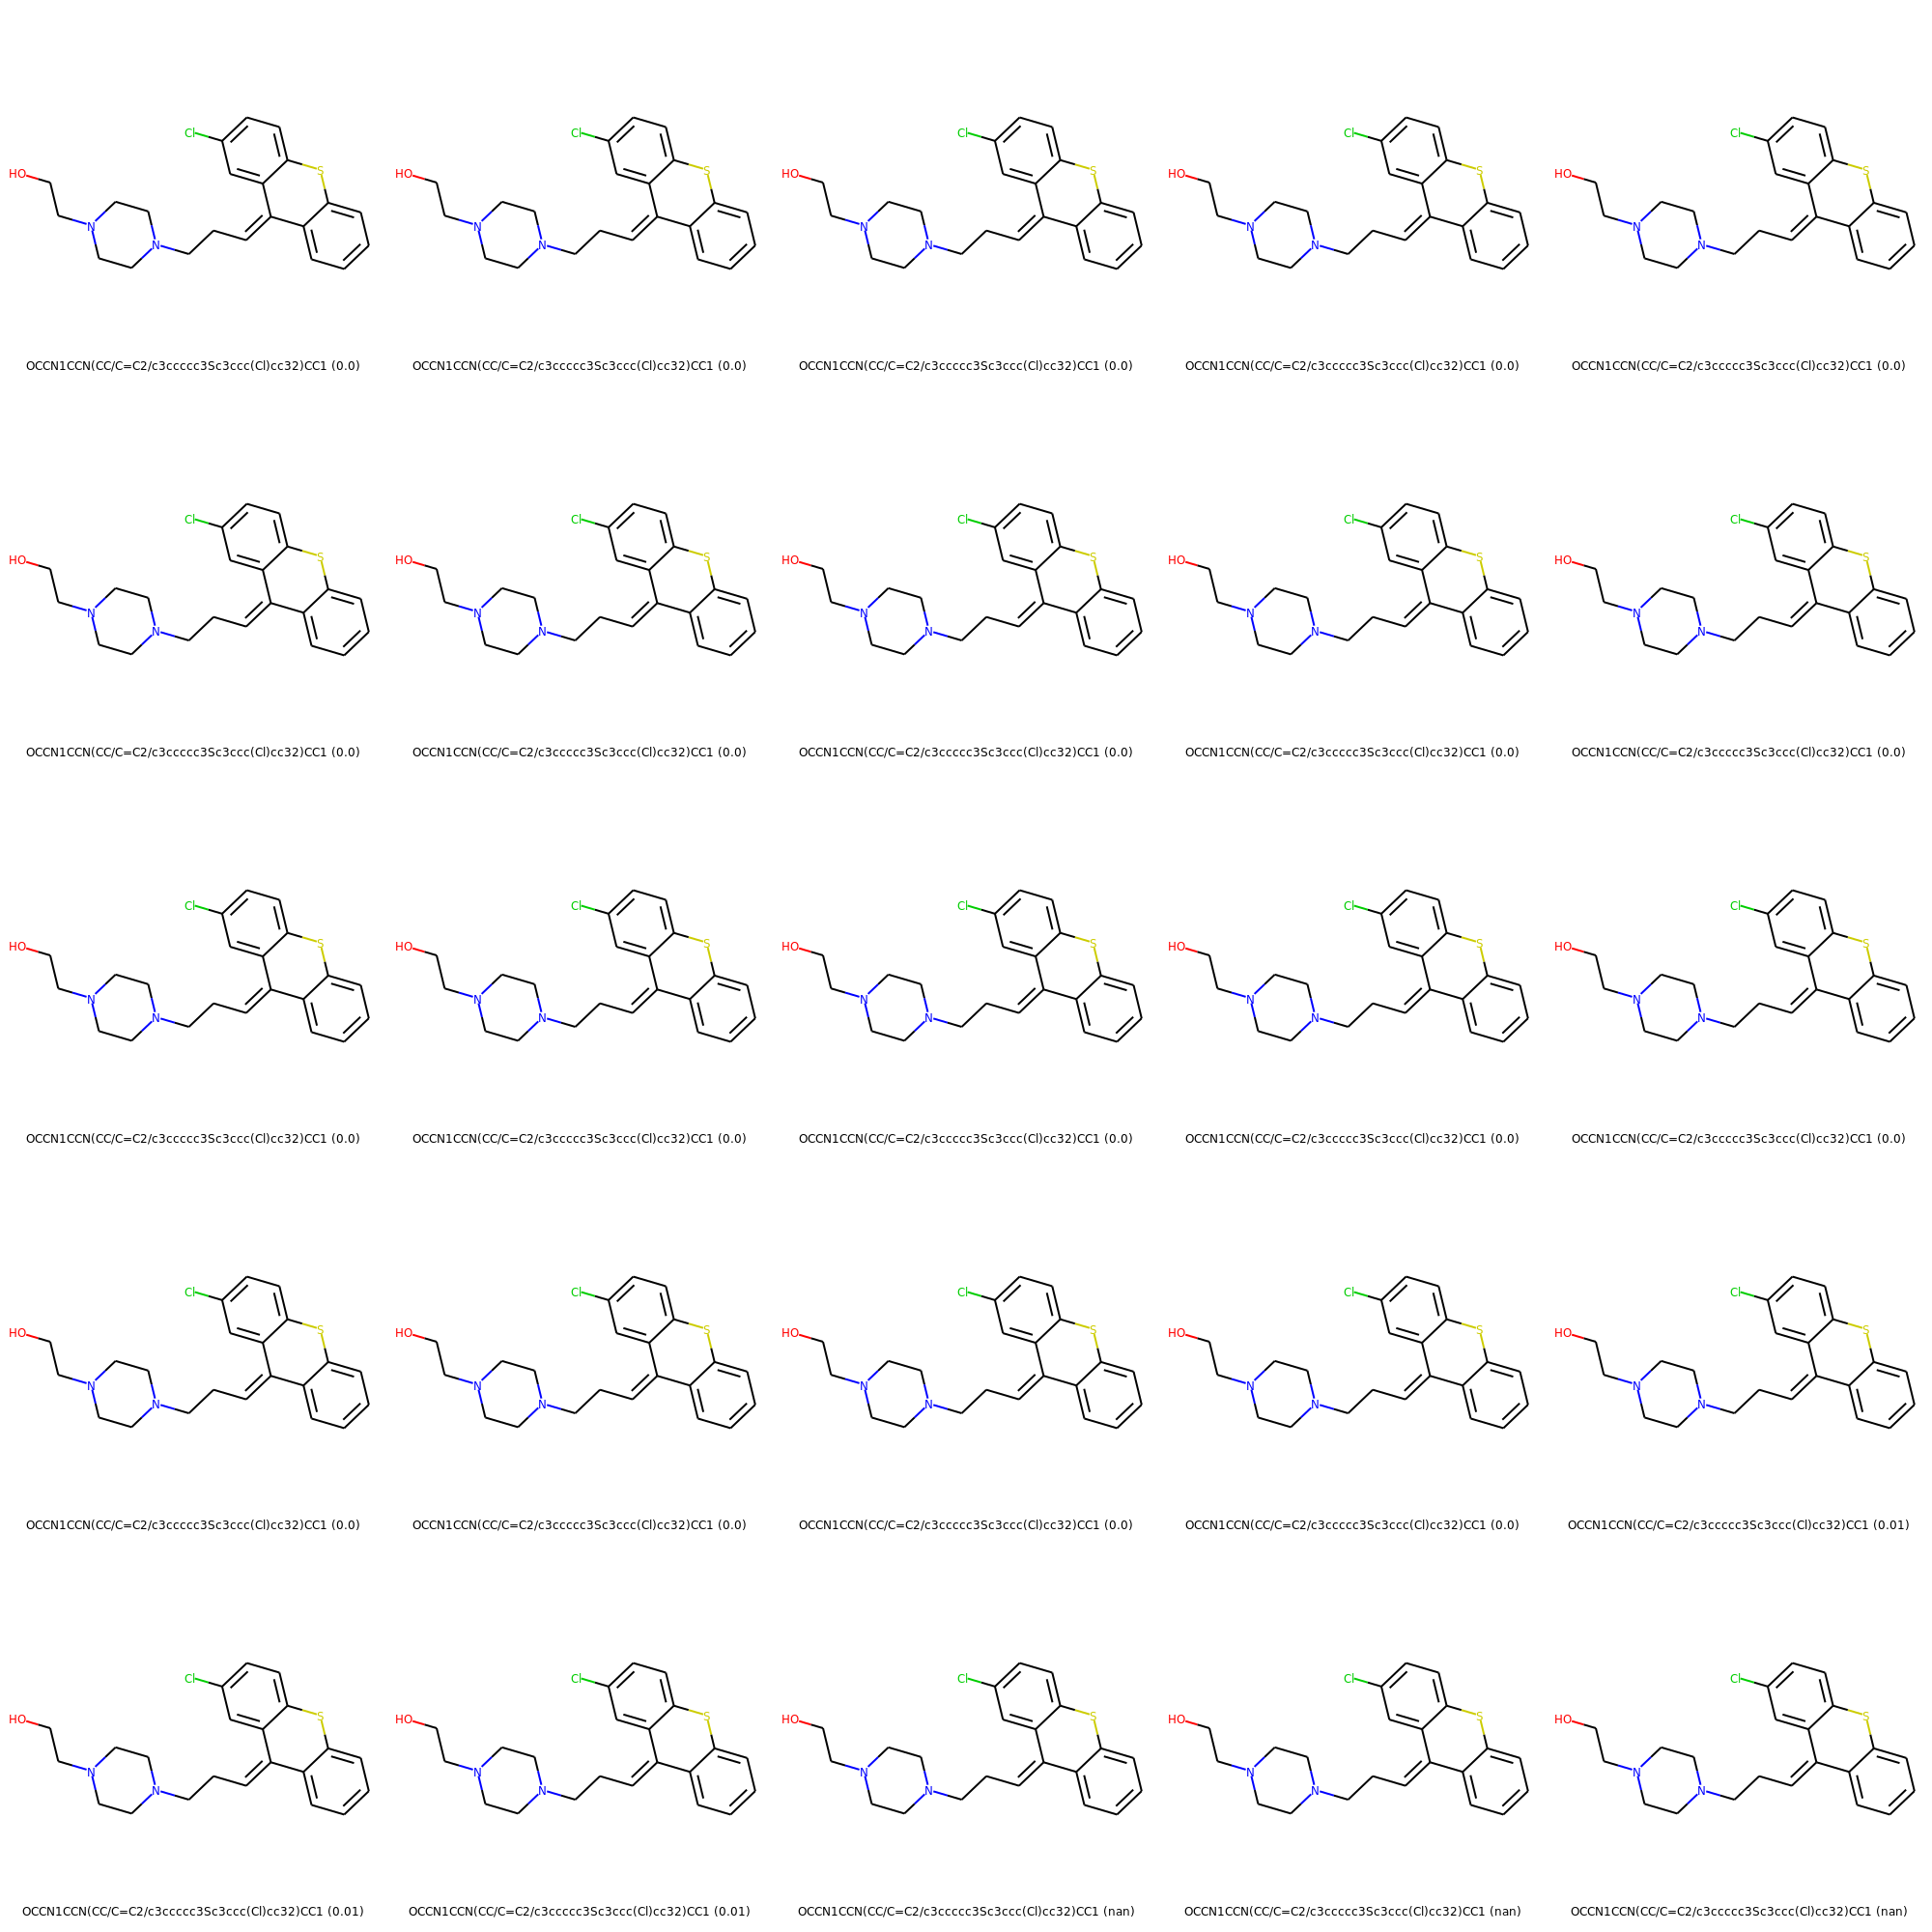

In [22]:
z_q_img_lst[1]

## Quality of posterior samples

### Test SMILES reconstruction quality

In [23]:
test_q_sample_quality_lst = posterior_samples_quality(configs_lst, mdl_lst, 'test')

In [24]:
test_q_sample_quality_lst[0].mean()

VALIDITY    0.891333
EXACT       0.731333
TANIMOTO    0.852179
dtype: float64

In [25]:
test_q_sample_quality_lst[1].mean()

VALIDITY    0.950000
EXACT       0.863333
TANIMOTO    0.935470
dtype: float64

### FDA drugs reconstruction quality

In [26]:
fda_q_sample_quality_lst = posterior_samples_quality(configs_lst, mdl_lst, 'fda')

In [27]:
fda_q_sample_quality_lst[0].mean()

VALIDITY    0.678700
EXACT       0.444043
TANIMOTO    0.589229
dtype: float64

In [28]:
fda_q_sample_quality_lst[1].mean()

VALIDITY    0.862816
EXACT       0.768953
TANIMOTO    0.839475
dtype: float64

# Sampling from Prior ~p(z)

## Plot exemplar SMILES used in VampPrior

In [54]:
# define experiments and checkpoints
vamp_checkpoints = [('zinc_fda_euc_vamp','checkpoint_epoch100.model'), 
                   ('zinc_fda_lor_vamp','checkpoint_epoch100.model')]

# load model objects into a list
vamp_configs_lst, vamp_mdl_lst = load_model(vamp_checkpoints)

# add new hyperparameters
#vamp_configs_lst[0]['prior_type'] = 'VampPrior'
#vamp_configs_lst[1]['prior_type'] = 'VampPrior'
#vamp_configs_lst[0]['num_centroids'] = 20
#vamp_configs_lst[1]['num_centroids'] = 20

# re-calculate cluster centroids
fda_batch = fda_dataloader(vamp_configs_lst[0])
exemplar_smiles_lst, exemplar_img_lst = plot_exemplar_smiles(fda_batch, vamp_configs_lst, vamp_mdl_lst)

why clustering result is different after each re-run? Need to fix random seeds?

In [55]:
configs = vamp_configs_lst[0]
model = vamp_mdl_lst[0]

exemplars_fda_euc = ['c1ccc([C@H]2CN3CCSC3=N2)cc1',
 'COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC',
 'CCC[C@H](N[C@@H](C)C(=O)N1[C@H](C(=O)O)C[C@@H]2CCCC[C@@H]21)C(=O)OCC',
 'CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)CSc3ccncc3)[C@H]2SC1',
 'COc1ccc(-n2nc(C(N)=O)c3c2C(=O)N(c2ccc(N4CCCCC4=O)cc2)CC3)cc1', 
 'CC(C)C[C@H](N)C(=O)O', 
 'Cc1ccc(S(=O)(=O)NC(=O)NN2CCCCCC2)cc1',
 'CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21', 
 'CC=CC(=O)N(CC)c1ccccc1C', 
 'OCC(S)CS', 
 'CNCC[C@@H](Oc1ccccc1C)c1ccccc1', 
 'CN1CCN(C(=O)OC2c3nccnc3C(=O)N2c2ccc(Cl)cn2)CC1', 
 'CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@@]21C', 
 'O=C(O)CCNC(=O)c1ccc(/N=N/c2ccc(O)c(C(=O)O)c2)cc1', 
 'CCN(CC)CCNC(=O)c1ccc(N)cc1', 
 'Nc1nc(Cl)nc2c1ncn2[C@H]1C[C@H](O)[C@@H](CO)O1', 
 'CC(C)[N+](C)(CCC(C(N)=O)(c1ccccc1)c1ccccc1)C(C)C', 
 'CCCN1C[C@H](CSC)C[C@@H]2c3cccc4[nH]cc(c34)C[C@H]21', 
 'CC(C)(N)Cc1ccccc1',
 'C/C(=C\\C(=O)OCCCCCCCCC(=O)O)C[C@@H]1OC[C@H](C[C@@H]2O[C@H]2[C@@H](C)[C@H](C)O)[C@@H](O)[C@H]1O']

# save to a file
with open('./data/centroids_fda_euc.txt', 'w') as f:
    f.writelines("%s\n" % smiles for smiles in exemplars_fda_euc)
f.close()

# generate textdata
centroids_euc = textdata(data_dir=configs['data_dir'], exp_dir='./data', split=None, vocab_file=configs['vocab_file'],
                    max_sequence_length=configs['max_sequence_length'], filename='centroids_fda_euc.txt')

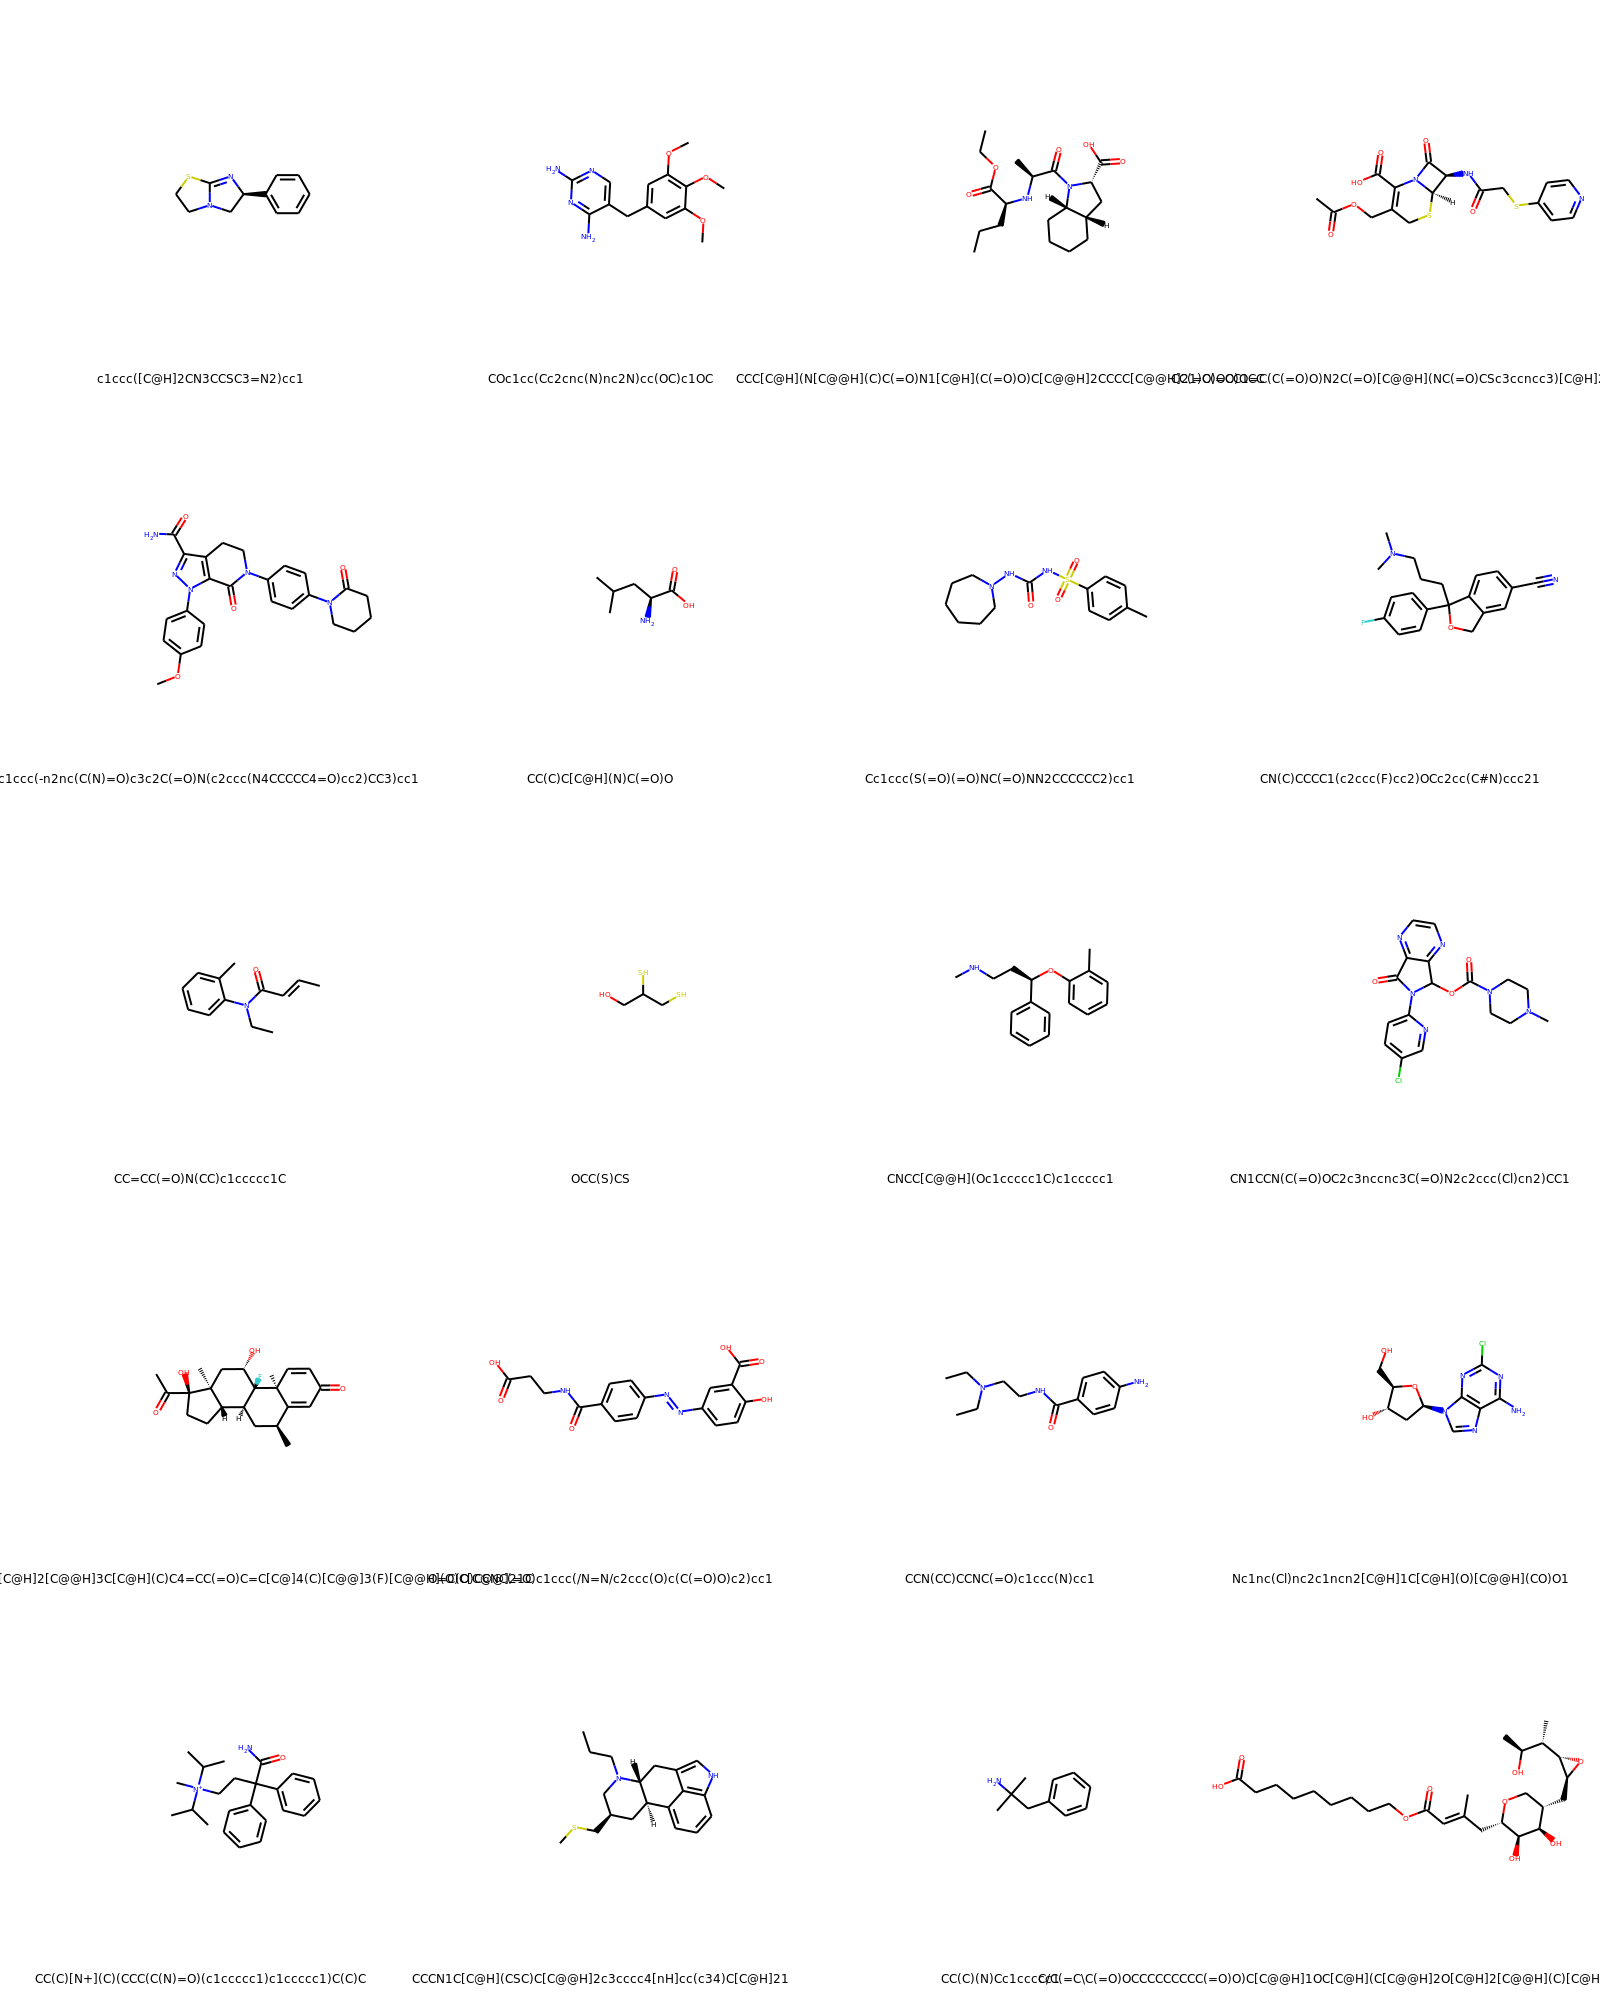

In [56]:
mol_grid=[]
for smi in exemplars_fda_euc:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass
Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=exemplars_fda_euc)

In [57]:
idx=atc_fda_inner.smile_x.isin(exemplars_fda_euc)
exemplars_euc_atc_df = atc_fda_inner[idx]
exemplars_euc_atc_df

,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1,active_ingredient,smile_x
72,apixaban,direct factor xa inhibitors,antithrombotic agents,antithrombotic agents,blood and blood forming organ drugs,apixaban,COc1ccc(-n2nc(C(N)=O)c3c2C(=O)N(c2ccc(N4CCCCC4...
128,fluorometholone,"corticosteroids, combinations for treatment of...",anti-acne preparations for topical use,anti-acne preparations,dermatologicals,fluorometholone,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=...
129,fluorometholone,corticosteroid ophthalmologic antiinflammatory...,"antiinflammatory agents, ophthalmologic",ophthalmologicals,sensory organ drugs,fluorometholone,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=...
130,fluorometholone,"corticosteroids, topical for treatment of hemo...",agents for treatment of hemorrhoids and anal f...,vasoprotectives,cardiovascular system drugs,fluorometholone,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=...
131,fluorometholone,corticosteroids/antiinfectives/mydriatics in c...,antiinflammatory agents and antiinfectives in ...,ophthalmologicals,sensory organ drugs,fluorometholone,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=...
132,fluorometholone,"corticosteroids, moderately potent, other comb...","corticosteroids, other combinations","corticosteroids, dermatological preparations",dermatologicals,fluorometholone,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=...
133,fluorometholone,"corticosteroids, moderately potent (group ii)","corticosteroid dermatological preparations, plain","corticosteroids, dermatological preparations",dermatologicals,fluorometholone,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](C)C4=CC(=...
173,zopiclone,benzodiazepine related hypnotics and sedatives,hypnotics and sedatives,psycholeptics,nervous system drugs,zopiclone,CN1CCN(C(=O)OC2c3nccnc3C(=O)N2c2ccc(Cl)cn2)CC1
215,tolazamide,sulfonylureas for blood glucose lowering,"blood glucose lowering drugs, excl. insulins",drugs used in diabetes,alimentary tract and metabolism drugs,tolazamide,Cc1ccc(S(=O)(=O)NC(=O)NN2CCCCCC2)cc1
359,levamisole,"imidazothiazole derivatives, antinematodal",antinematodal agents,anthelmintics,"antiparasitic products, insecticides and repel...",levamisole,c1ccc([C@H]2CN3CCSC3=N2)cc1


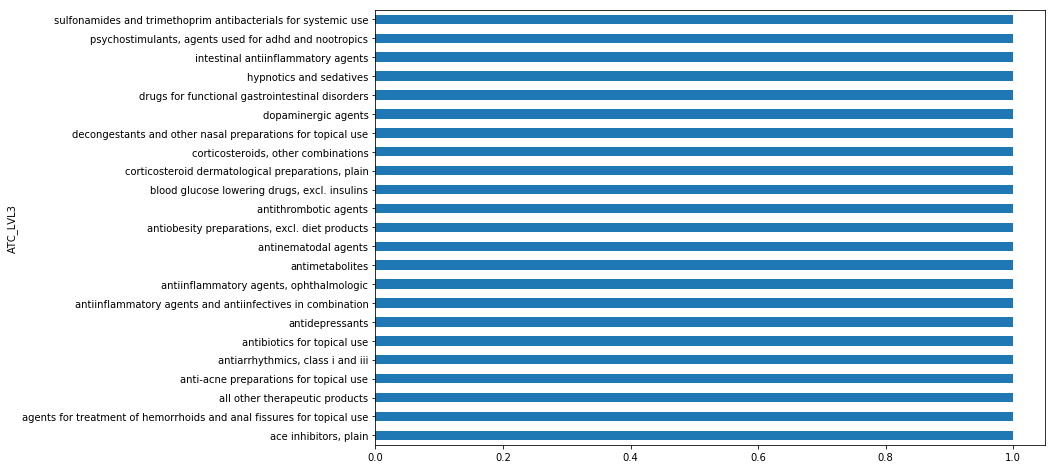

In [58]:
plt.figure(figsize=(12, 8))
exemplars_euc_atc_df.groupby('ATC_LVL3')['ATC_LVL5'].nunique().plot(kind='barh')

In [59]:
configs = vamp_configs_lst[1]
model = vamp_mdl_lst[1]

exemplars_fda_lor = ['CCC1NC(=O)c2cc(S(N)(=O)=O)c(Cl)cc2N1',
 'Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1',
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1',
 'OCCN1CCN(CC/C=C2/c3ccccc3Sc3ccc(Cl)cc32)CC1',
 'Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(=O)[nH]c1=O',
 'Cc1c(F)c(N2CCNC(C)C2)cc2c1c(=O)c(C(=O)O)cn2C1CC1',
 'CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1',
 'Oc1ccc(C2CNCCc3c2cc(O)c(O)c3Cl)cc1',
 'CN(C)CCOC(c1ccc(Cl)cc1)c1ccccn1',
 'C=C1/C(=C\\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H](C)CCCC(C)C)C[C@@H](O)C[C@@H]1O',
 'C/C=C(/C)C(=O)O[C@H]1C(C)=C[C@]23C(=O)[C@@H](C=C(CO)[C@@H](O)[C@]12O)[C@H]1[C@@H](C[C@H]3C)C1(C)C',
 'CC(C(=O)O)c1ccc(C(=O)c2cccs2)cc1',
 'Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@@H]1O',
 'N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O',
 'CC(C)[C@H](N)C(=O)OCCOCn1cnc2c(=O)nc(N)[nH]c21',
 'CCC(c1ccccc1)c1c(O)c2ccccc2oc1=O', 
 'CCCCCCCC/C=C\\CCCCCCCC(=O)O',
 'C[C@H](N)Cc1ccccc1',
 'CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1',
 'C[N+]1(CCCCC[N+]2(C)CCCC2)CCCC1']

# save to a file
with open('./data/centroids_fda_lor.txt', 'w') as f:
    f.writelines("%s\n" % smiles for smiles in exemplars_fda_lor)
f.close()

# generate textdata
centroids_lor = textdata(data_dir=configs['data_dir'], exp_dir='./data', split=None, vocab_file=configs['vocab_file'],
                    max_sequence_length=configs['max_sequence_length'], filename='centroids_fda_lor.txt')

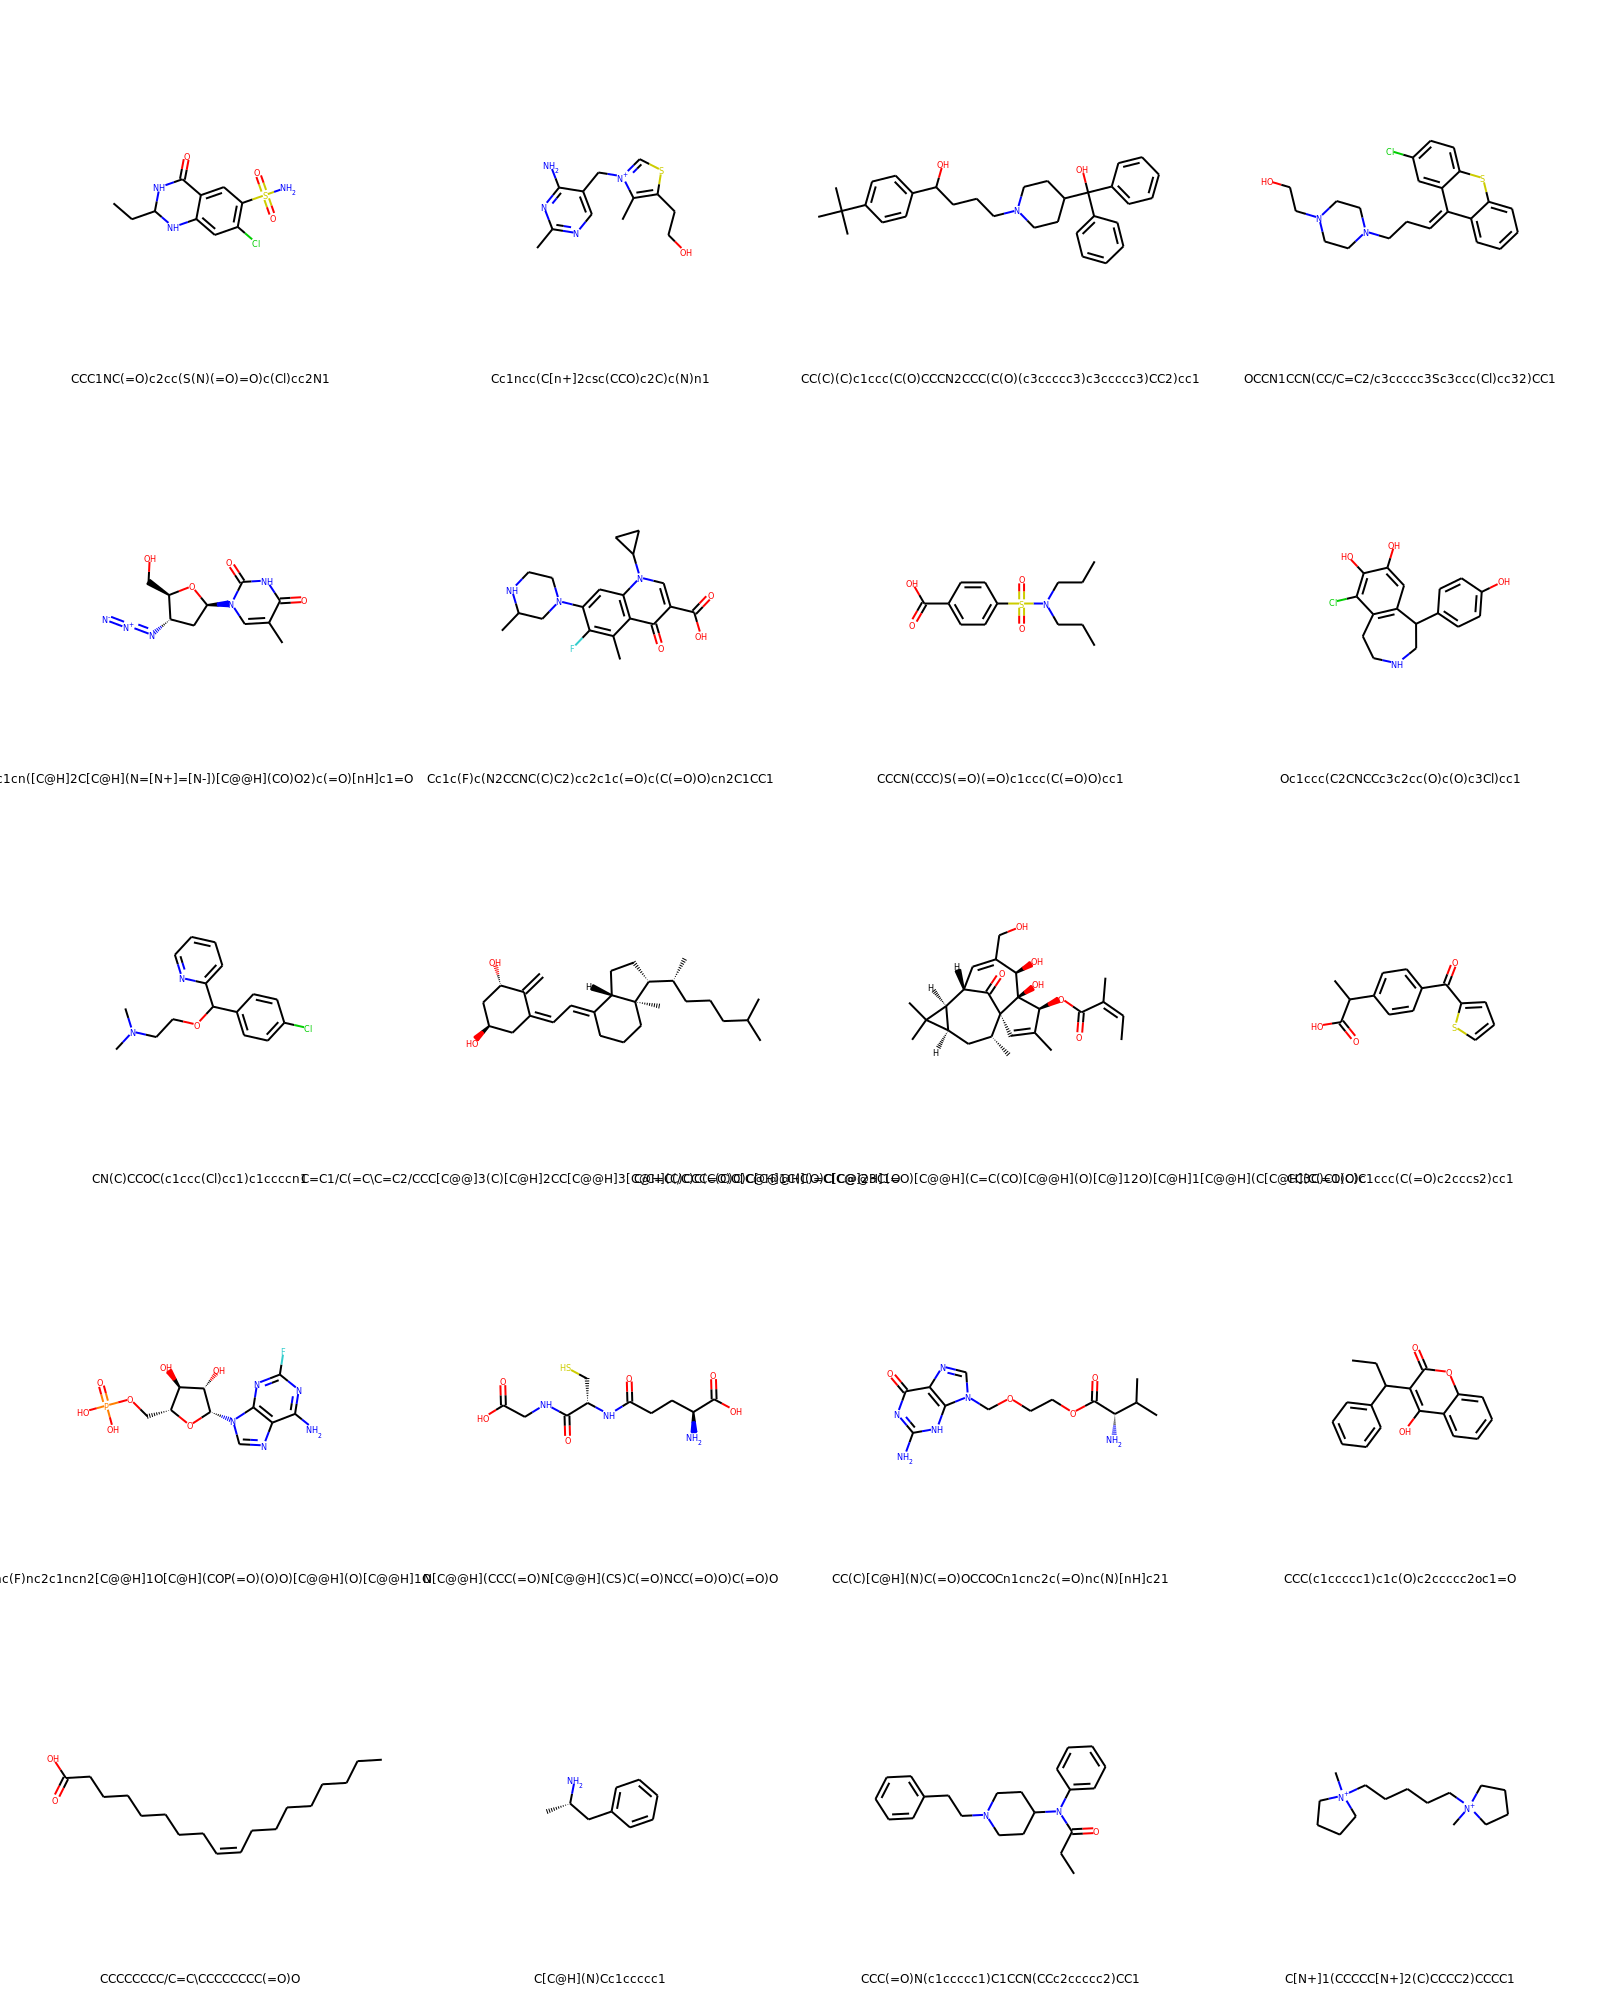

In [60]:
mol_grid=[]
for smi in exemplars_fda_lor:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass
Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=exemplars_fda_lor)

In [61]:
idx=atc_fda_inner.smile_x.isin(exemplars_fda_lor)
exemplars_lor_atc_df = atc_fda_inner[idx]
exemplars_lor_atc_df

,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1,active_ingredient,smile_x
32,valaciclovir,nucleosides and nucleotides excl. reverse tran...,direct acting antivirals,antivirals for systemic use,antiinfectives for systemic use,valaciclovir,CC(C)[C@H](N)C(=O)OCCOCn1cnc2c(=O)nc(N)[nH]c21
253,fentanyl,opioid anesthetics,"anesthetics, general",anesthetics,nervous system drugs,fentanyl,CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1
254,fentanyl,"phenylpiperidine derivatives, opioid analgesics",opioid analgesics,analgesics,nervous system drugs,fentanyl,CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1
266,alfacalcidol,vitamin d and analogues,"vitamin a and d, incl. combinations of the two",vitamins,alimentary tract and metabolism drugs,alfacalcidol,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...
303,terfenadine,other antihistamines for systemic use in atc,antihistamines for systemic use,antihistamines for systemic use,respiratory system drugs,terfenadine,CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...
463,suprofen,"propionic acid derivatives, antiinflammatory a...","antiinflammatory and antirheumatic products, n...",antiinflammatory and antirheumatic products,musculo-skeletal system drugs,suprofen,CC(C(=O)O)c1ccc(C(=O)c2cccs2)cc1
615,zidovudine,nucleoside and nucleotide reverse transcriptas...,direct acting antivirals,antivirals for systemic use,antiinfectives for systemic use,zidovudine,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...
653,probenecid,preparations increasing uric acid excretion,antigout preparations,antigout preparations,musculo-skeletal system drugs,probenecid,CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1
795,zuclopenthixol,"thioxanthene derivatives, antipsychotic",antipsychotics,psycholeptics,nervous system drugs,zuclopenthixol,OCCN1CCN(CC/C=C2/c3ccccc3Sc3ccc(Cl)cc32)CC1
834,grepafloxacin,"fluoroquinolone antibacterials, systemic",quinolone antibacterials,antibacterials for systemic use,antiinfectives for systemic use,grepafloxacin,Cc1c(F)c(N2CCNC(C)C2)cc2c1c(=O)c(C(=O)O)cn2C1CC1


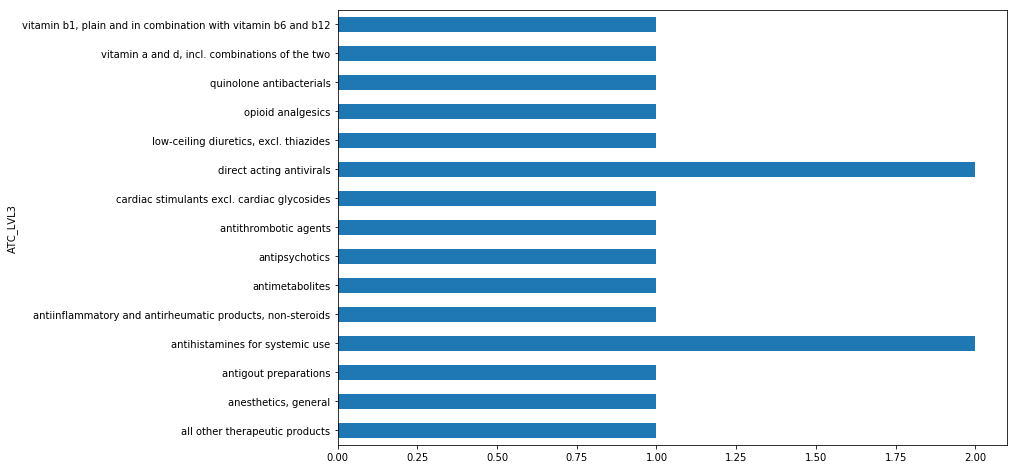

In [62]:
plt.figure(figsize=(12, 8))
exemplars_lor_atc_df.groupby('ATC_LVL3')['ATC_LVL5'].nunique().plot(kind='barh')

## Plot prior samples

In [66]:
# add new hyperparameters
configs_lst[0]['centroids'] = centroids_lor
configs_lst[1]['centroids'] = centroids_lor

CONTINUE WORKING FROM HERE

In [67]:
z_p_img_lst = greedy_prior_samples(configs_lst, mdl_lst, nsamples=16)

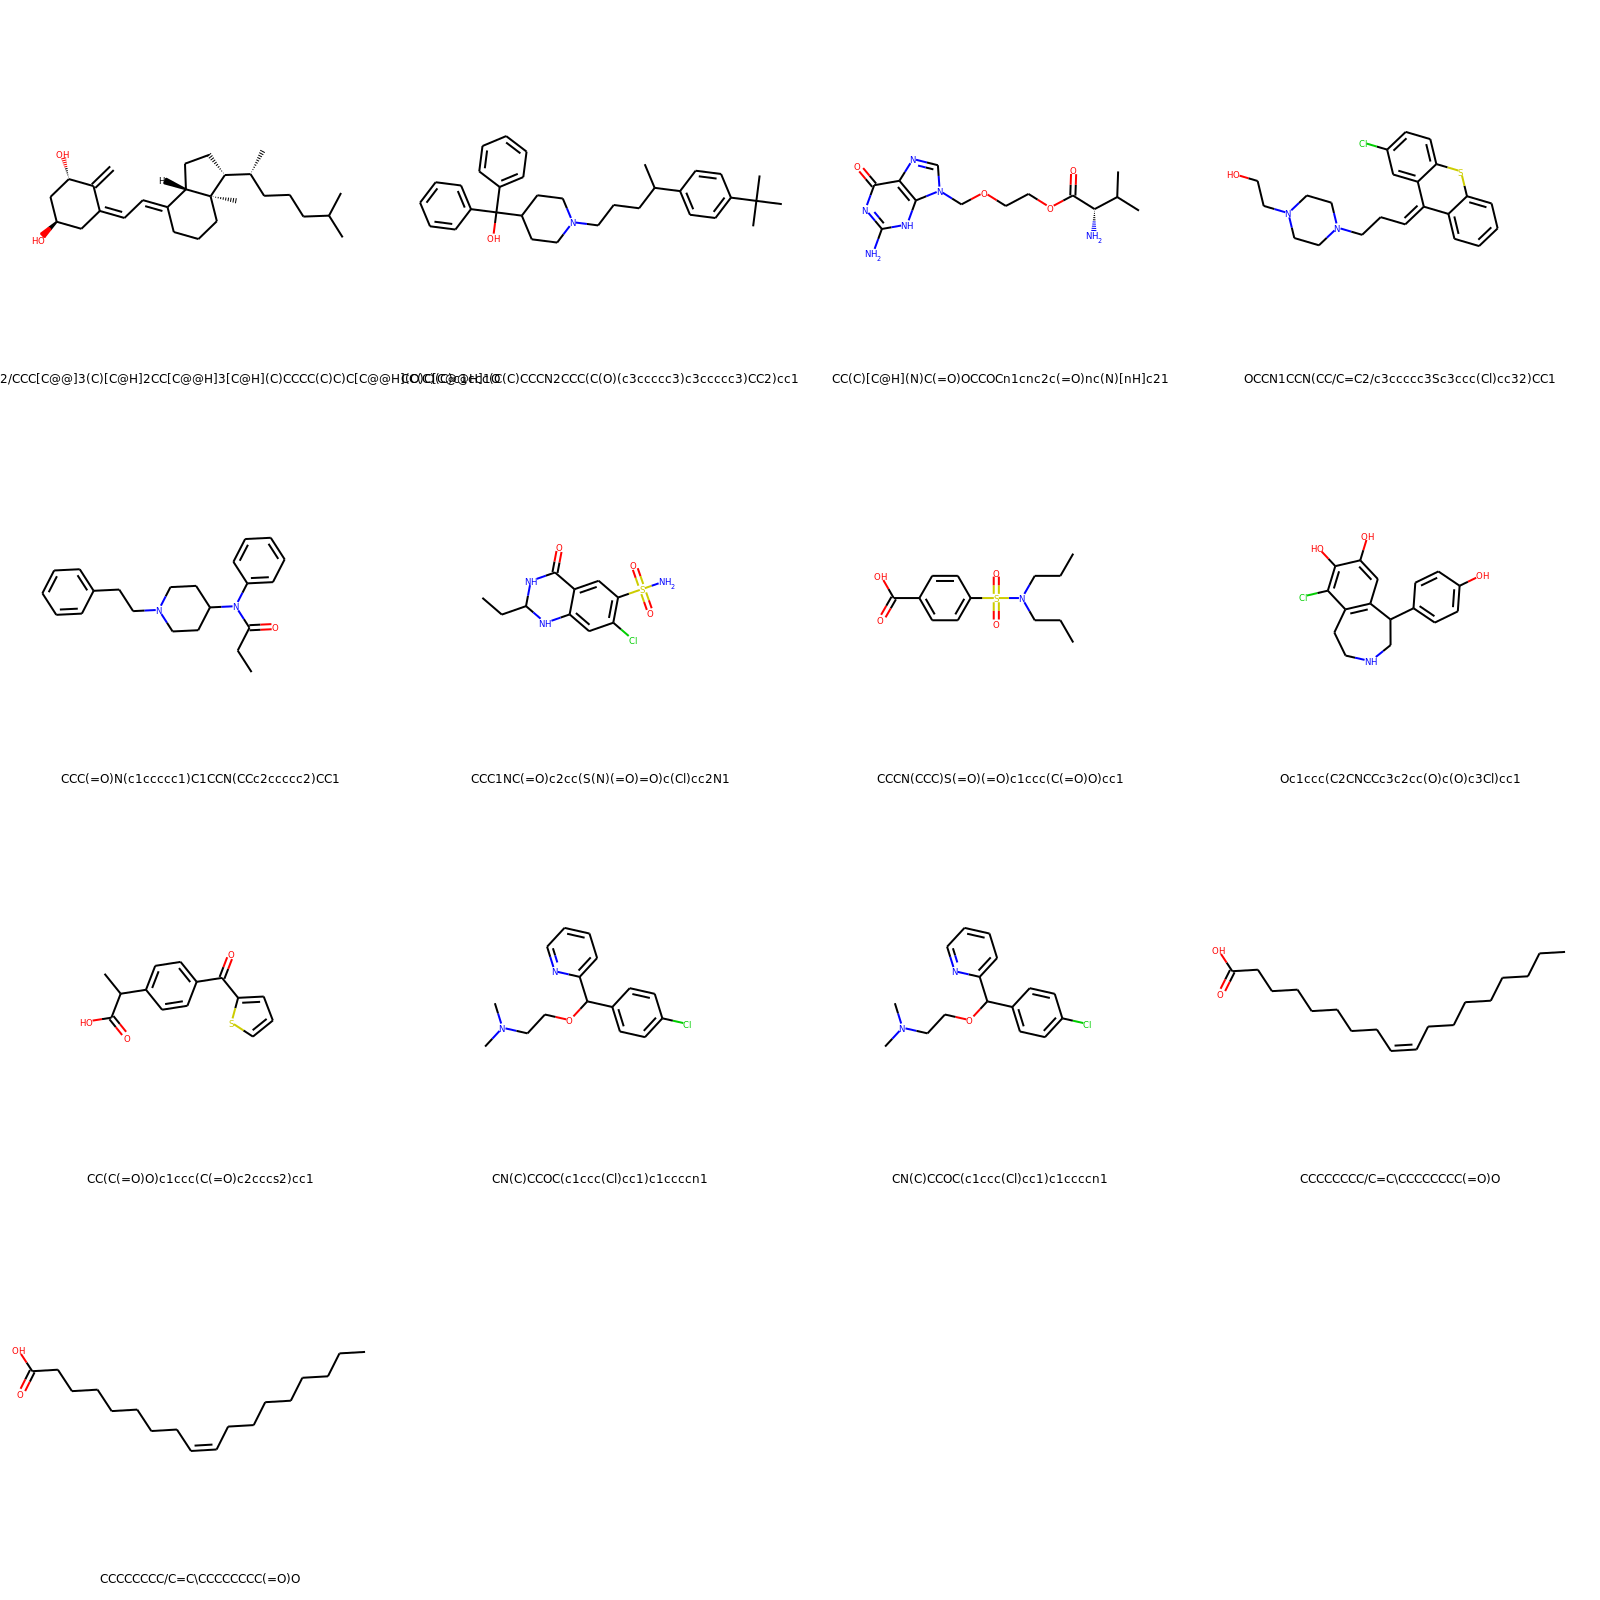

In [68]:
z_p_img_lst[0]

## Quality of prior samples

In [69]:
p_sample_quality_lst = prior_samples_quality(configs_lst, mdl_lst, nsamples=1000)

In [72]:
# perc_valid, perc_chem_valid, perc_unique, perc_novel
p_sample_quality_lst[0]

(0.793, 0.793, 0.03909205548549811, 0.13745271122320302)

# Clustering performance

## Hierarchical Clustering

In [29]:
# prepare dictionary of durgs mean ~q(z|x)
drugs_mu_dict_lst = drugs_mu_dict_creator(configs_lst, mdl_lst)

In [55]:
fda_drugs_culster_df_lst =  drug_hier_path(configs_lst, mdl_lst, drugs_mu_dict_lst)

In [59]:
mdl_idx = 0
fda_drugs_culster_df = fda_drugs_culster_df_lst[mdl_idx]

### complete hierarchy

In [62]:
fda_drugs_culster_df

,index,cluster_1,cluster_2,cluster,distance,num_samples
0,1365,[aminophylline],[theophylline],"[aminophylline, theophylline]",0.000000,2.0
1,1366,[salicylate-sodium],[trisalicylate-choline],"[salicylate-sodium, trisalicylate-choline]",0.000000,2.0
2,1367,[dihydroergotoxine],[ergotamine],"[dihydroergotoxine, ergotamine]",0.201250,2.0
3,1368,[daunorubicin],[doxorubicin],"[daunorubicin, doxorubicin]",0.301852,2.0
4,1369,[flunisolide],[flurandrenolide],"[flunisolide, flurandrenolide]",0.341484,2.0
5,1370,[hydrocortisone],[prednisolone],"[hydrocortisone, prednisolone]",0.509814,2.0
6,1371,[epirubicin],"[daunorubicin, doxorubicin]","[epirubicin, daunorubicin, doxorubicin]",0.520615,3.0
7,1372,[levonorgestrel],[norethindrone],"[levonorgestrel, norethindrone]",0.523306,2.0
8,1373,[demeclocycline],[tetracycline],"[demeclocycline, tetracycline]",0.557617,2.0
9,1374,[betamethasone],[clobetasol],"[betamethasone, clobetasol]",0.559129,2.0


### drug specific hierarchy

In [64]:
# drug specific hierachy
drug_x = ['moexipril']
fda_drugs_culster_df_lst[0][pd.DataFrame(fda_drugs_culster_df_lst[0].cluster.tolist()).isin(drug_x).any(1)]

,index,cluster_1,cluster_2,cluster,distance,num_samples
144,1509,[moexipril],[quinapril],"[moexipril, quinapril]",3.017929,2.0
414,1779,"[moexipril, quinapril]","[enalapril, spirapril]","[moexipril, quinapril, enalapril, spirapril]",5.209462,4.0
596,1961,"[ramipril, trandolapril]","[moexipril, quinapril, enalapril, spirapril]","[ramipril, trandolapril, moexipril, quinapril,...",6.073175,6.0
1136,2501,"[benazepril, cilazapril]","[ramipril, trandolapril, moexipril, quinapril,...","[benazepril, cilazapril, ramipril, trandolapri...",9.529317,8.0
1272,2637,"[cinalukast, adefovir, afatinib, dabigatran, i...","[benazepril, cilazapril, ramipril, trandolapri...","[cinalukast, adefovir, afatinib, dabigatran, i...",11.780554,15.0
1329,2694,"[cinalukast, adefovir, afatinib, dabigatran, i...","[nadolol, valsartan, dronabinol, nabilone, tic...","[cinalukast, adefovir, afatinib, dabigatran, i...",14.352253,25.0
1337,2702,"[posaconazole, tipranavir, boceprevir, saquina...","[cinalukast, adefovir, afatinib, dabigatran, i...","[posaconazole, tipranavir, boceprevir, saquina...",15.005211,82.0
1345,2710,"[darifenacin, regadenoson, lapatinib, abirater...","[posaconazole, tipranavir, boceprevir, saquina...","[darifenacin, regadenoson, lapatinib, abirater...",16.018505,101.0
1348,2713,"[pentosan, atazanavir, gadofosveset, lercanidi...","[darifenacin, regadenoson, lapatinib, abirater...","[pentosan, atazanavir, gadofosveset, lercanidi...",16.495247,179.0
1356,2721,"[pentosan, atazanavir, gadofosveset, lercanidi...","[glucosamine, mannitol, miglitol, erythrityl, ...","[pentosan, atazanavir, gadofosveset, lercanidi...",19.038819,420.0


In [65]:
fda_drugs_culster_df_lst[1][pd.DataFrame(fda_drugs_culster_df_lst[1].cluster.tolist()).isin(drug_x).any(1)]

,index,cluster_1,cluster_2,cluster,distance,num_samples
215,1580,[moexipril],[quinapril],"[moexipril, quinapril]",3.195033,2.0
391,1756,"[moexipril, quinapril]","[enalapril, spirapril]","[moexipril, quinapril, enalapril, spirapril]",3.804835,4.0
454,1819,[benazepril],"[moexipril, quinapril, enalapril, spirapril]","[benazepril, moexipril, quinapril, enalapril, ...",3.920264,5.0
867,2232,"[benazepril, moexipril, quinapril, enalapril, ...","[cilazapril, ramipril, trandolapril]","[benazepril, moexipril, quinapril, enalapril, ...",4.550447,8.0
1117,2482,"[balsalazide, progabide, rivaroxaban]","[benazepril, moexipril, quinapril, enalapril, ...","[balsalazide, progabide, rivaroxaban, benazepr...",4.969312,11.0
1154,2519,"[diltiazem, trimethobenzamide]","[balsalazide, progabide, rivaroxaban, benazepr...","[diltiazem, trimethobenzamide, balsalazide, pr...",5.027571,13.0
1263,2628,"[cefaclor, loracarbef, ceftizoxime, cefotaxime...","[diltiazem, trimethobenzamide, balsalazide, pr...","[cefaclor, loracarbef, ceftizoxime, cefotaxime...",5.356446,37.0
1296,2661,"[ezetimibe, nicergoline, sertraline, eszopiclo...","[cefaclor, loracarbef, ceftizoxime, cefotaxime...","[ezetimibe, nicergoline, sertraline, eszopiclo...",5.496955,74.0
1326,2691,"[ezetimibe, nicergoline, sertraline, eszopiclo...","[melphalan, oxaliplatin, uracil, emtricitabine...","[ezetimibe, nicergoline, sertraline, eszopiclo...",5.706935,119.0
1332,2697,"[pentamidine, terfenadine, buclizine, cinnariz...","[ezetimibe, nicergoline, sertraline, eszopiclo...","[pentamidine, terfenadine, buclizine, cinnariz...",5.790221,200.0


In [69]:
# SMILES graph visualization
drugs_mu_dict = drugs_mu_dict_lst[0]

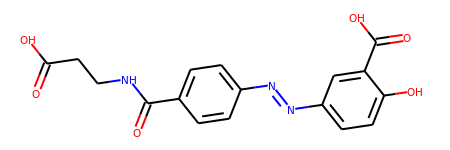

In [70]:
d1 = drugs_mu_dict['balsalazide']
m1 = Chem.MolFromSmiles(d1[0])
m1

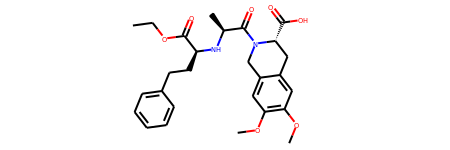

In [71]:
d1 = drugs_mu_dict['moexipril']
m1 = Chem.MolFromSmiles(d1[0])
m1

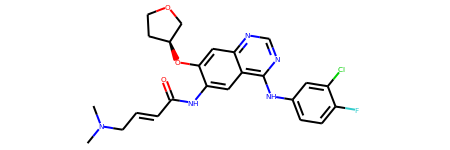

In [72]:
d1 = drugs_mu_dict['afatinib']
m1 = Chem.MolFromSmiles(d1[0])
m1

## Normalized mutual information

In [124]:
atc_fda_inner.head()

,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1,active_ingredient,smile_x
0,promethazine,antihistamines for topical use,"antipruritics, incl. antihistamines, anestheti...","antipruritics, incl. antihistamines, anestheti...",dermatologicals,promethazine,CC(CN1c2ccccc2Sc2ccccc21)N(C)C
1,promethazine,"phenothiazine derivatives, systemic antihistam...",antihistamines for systemic use,antihistamines for systemic use,respiratory system drugs,promethazine,CC(CN1c2ccccc2Sc2ccccc21)N(C)C
2,cilostazol,platelet aggregation inhibitors excl. heparin,antithrombotic agents,antithrombotic agents,blood and blood forming organ drugs,cilostazol,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1
3,emtricitabine,nucleoside and nucleotide reverse transcriptas...,direct acting antivirals,antivirals for systemic use,antiinfectives for systemic use,emtricitabine,Nc1nc(=O)n([C@@H]2CS[C@H](CO)O2)cc1F
4,imiquimod,"antivirals, topical",chemotherapeutics for topical use,antibiotics and chemotherapeutics for dermatol...,dermatologicals,imiquimod,CC(C)Cn1cnc2c(N)nc3ccccc3c21


In [148]:
atc_fda_inner.describe()

,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1,active_ingredient,smile_x
count,1355,1355,1355,1355,1355,1355,1355
unique,1055,408,157,73,14,1055,1054
top,dexamethasone,"protein kinase inhibitors, antineoplastic drugs",other antineoplastic agents in atc,antibacterials for systemic use,nervous system drugs,dexamethasone,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...
freq,11,18,39,100,252,11,11


In [154]:
def atc_cluster_mutual_info(configs, model, drugs_mu_dict):
    # Combine drugs latent representations into a matrix
    drug_lst=[]
    smile_lst=[]
    gen_smile_lst=[]
    latent_lst=[]
    label_lst=[]
    ATC_LVL1_lst=[]
    ATC_LVL2_lst=[]
    ATC_LVL3_lst=[]
    ATC_LVL4_lst=[]
    for key in drugs_mu_dict.keys():
        h = drugs_mu_dict[key][2]
        latent_lst.append(h)
        drug_lst.append(key)
        smile_lst.append(drugs_mu_dict[key][0])
        gen_smile_lst.append(drugs_mu_dict[key][1])
        try:
            ATC_LVL1_lst.append(atc_fda_inner[atc_fda_inner.ATC_LVL5==key].ATC_LVL1.mode()[0])
            ATC_LVL2_lst.append(atc_fda_inner[atc_fda_inner.ATC_LVL5==key].ATC_LVL2.mode()[0])
            ATC_LVL3_lst.append(atc_fda_inner[atc_fda_inner.ATC_LVL5==key].ATC_LVL3.mode()[0])
            ATC_LVL4_lst.append(atc_fda_inner[atc_fda_inner.ATC_LVL5==key].ATC_LVL4.mode()[0])
        except:
            ATC_LVL1_lst.append('UNK')
            ATC_LVL2_lst.append('UNK')
            ATC_LVL3_lst.append('UNK')
            ATC_LVL4_lst.append('UNK')  
        #label_lst.append(key+'<br>'+drugs_mu_dict[key][0]+'<br>'+drugs_mu_dict[key][1])
    latent_reps = np.asarray(latent_lst).squeeze()
    nsamples, _ = latent_reps.shape
    dist_condensed = pairwise_dist(configs['manifold_type'],latent_reps)
    dist_condensed[np.isnan(dist_condensed)] = 0
    dist_mtrx = spatial.distance.squareform(dist_condensed)
    
    mutual_info_dict = {}
    
    # ATC Level 1
    ATC_LVL1_array = np.asarray(ATC_LVL1_lst)
    idx = np.asarray(ATC_LVL1_lst) != 'UNK'
    ATC_LVL1_clean = ATC_LVL1_array[idx]
    ncluster = 14
    hcluster = AgglomerativeClustering(n_clusters = ncluster, affinity='precomputed', linkage='complete')
    cluster_lor = hcluster.fit(dist_mtrx)
    cluster_labels = cluster_lor.labels_
    cluster_labels_clean = cluster_labels[idx]
    # normalized mutual information
    atc_lvl1_ami = metrics.adjusted_mutual_info_score(ATC_LVL1_clean,cluster_labels_clean, average_method='arithmetic')
    atc_lvl1_nmi = metrics.normalized_mutual_info_score(ATC_LVL1_clean,cluster_labels_clean, average_method='arithmetic')
    
    mutual_info_dict['ATC_LVL_1'] = {'AMI':atc_lvl1_ami, 'NMI':atc_lvl1_nmi}
    
    
    # ATC Level 2
    ATC_LVL2_array = np.asarray(ATC_LVL2_lst)
    idx = np.asarray(ATC_LVL2_lst) != 'UNK'
    ATC_LVL2_clean = ATC_LVL2_array[idx]
    ncluster = 73
    hcluster = AgglomerativeClustering(n_clusters = ncluster, affinity='precomputed', linkage='complete')
    cluster_lor = hcluster.fit(dist_mtrx)
    cluster_labels = cluster_lor.labels_
    cluster_labels_clean = cluster_labels[idx]
    # normalized mutual information
    atc_lvl2_ami = metrics.adjusted_mutual_info_score(ATC_LVL2_clean,cluster_labels_clean, average_method='arithmetic')
    atc_lvl2_nmi = metrics.normalized_mutual_info_score(ATC_LVL2_clean,cluster_labels_clean, average_method='arithmetic')
    
    mutual_info_dict['ATC_LVL_2'] = {'AMI':atc_lvl2_ami, 'NMI':atc_lvl2_nmi}
    
    # ATC Level 3
    ATC_LVL3_array = np.asarray(ATC_LVL3_lst)
    idx = np.asarray(ATC_LVL3_lst) != 'UNK'
    ATC_LVL3_clean = ATC_LVL3_array[idx]
    ncluster = 157
    hcluster = AgglomerativeClustering(n_clusters = ncluster, affinity='precomputed', linkage='complete')
    cluster_lor = hcluster.fit(dist_mtrx)
    cluster_labels = cluster_lor.labels_
    cluster_labels_clean = cluster_labels[idx]
    # normalized mutual information
    atc_lvl3_ami = metrics.adjusted_mutual_info_score(ATC_LVL3_clean,cluster_labels_clean, average_method='arithmetic')
    atc_lvl3_nmi = metrics.normalized_mutual_info_score(ATC_LVL3_clean,cluster_labels_clean, average_method='arithmetic')
    
    mutual_info_dict['ATC_LVL_3'] = {'AMI':atc_lvl3_ami, 'NMI':atc_lvl3_nmi}
    
    # ATC Level 4
    ATC_LVL4_array = np.asarray(ATC_LVL4_lst)
    idx = np.asarray(ATC_LVL4_lst) != 'UNK'
    ATC_LVL4_clean = ATC_LVL4_array[idx]
    ncluster = 408
    hcluster = AgglomerativeClustering(n_clusters = ncluster, affinity='precomputed', linkage='complete')
    cluster_lor = hcluster.fit(dist_mtrx)
    cluster_labels = cluster_lor.labels_
    cluster_labels_clean = cluster_labels[idx]
    # normalized mutual information
    atc_lvl4_ami = metrics.adjusted_mutual_info_score(ATC_LVL4_clean,cluster_labels_clean, average_method='arithmetic')
    atc_lvl4_nmi = metrics.normalized_mutual_info_score(ATC_LVL4_clean,cluster_labels_clean, average_method='arithmetic')
    
    mutual_info_dict['ATC_LVL_4'] = {'AMI':atc_lvl4_ami, 'NMI':atc_lvl4_nmi}
    
    return mutual_info_dict

In [155]:
configs = configs_lst[0]
model = mdl_lst[0]
drugs_mu_dict = drugs_mu_dict_lst[0]
atc_cluster_mutual_info(configs, model, drugs_mu_dict)

{'ATC_LVL_1': {'AMI': 0.06359027104525243, 'NMI': 0.09708233534572003},
 'ATC_LVL_2': {'AMI': 0.15393231049189304, 'NMI': 0.4121256696814149},
 'ATC_LVL_3': {'AMI': 0.1773719561105666, 'NMI': 0.6078193407445769},
 'ATC_LVL_4': {'AMI': 0.19783605386000191, 'NMI': 0.8152611298932402}}

In [156]:
configs = configs_lst[1]
model = mdl_lst[1]
drugs_mu_dict = drugs_mu_dict_lst[1]
atc_cluster_mutual_info(configs, model, drugs_mu_dict)

/home/yuke/PythonProject/MolEmbedding/clustering.py:18: RuntimeWarning: invalid value encountered in sqrt
  dm = np.log(m + np.sqrt(m ** 2 - 1))


{'ATC_LVL_1': {'AMI': 0.06667375010489703, 'NMI': 0.09767448776518055},
 'ATC_LVL_2': {'AMI': 0.1843585051469937, 'NMI': 0.4225502402657521},
 'ATC_LVL_3': {'AMI': 0.2118268914430965, 'NMI': 0.6102161960798391},
 'ATC_LVL_4': {'AMI': 0.2500587182078627, 'NMI': 0.8180390904831308}}

## Average pairwise distance at level 5

In [90]:
drugs_mu_dict_lst[1]['ibuprofen']

['CC(C)Cc1ccc(C(C)C(=O)O)cc1',
 'CC(C)Cc1ccc(C(C)=C(C)O)cc1',
 array([[ 9.367094  , -2.2896526 ,  0.5869038 , -1.6666712 , -1.862764  ,
          1.5477846 , -0.6661243 ,  1.2491348 ,  0.66999346,  1.4541583 ,
         -3.2758758 ,  1.687092  , -0.40703207, -0.41733178,  2.227392  ,
         -0.75059146, -0.47800857,  0.00981158, -1.3134289 , -1.0643282 ,
         -0.4074752 , -1.678524  , -1.6488831 ,  0.85272163,  2.1248229 ,
         -0.83235425,  3.1436946 ,  0.49667394, -0.9086746 , -1.7069858 ,
         -0.98431724, -1.1808949 , -2.5231395 ,  1.1968486 ,  1.4513584 ,
         -1.7167366 , -0.1402389 ,  0.23108739, -1.4776838 ,  1.5110277 ,
          0.3929161 ]], dtype=float32)]

In [134]:
configs = configs_lst[6]
model = mdl_lst[6]
# step 2: compute the posterior means for FDA drugs
fda_drugs = 'all_drugs.smi'
fda_drugs_path = os.path.join('./data/', fda_drugs)

w2i, i2w = idx2word(configs['data_dir'], configs['vocab_file'])

In [135]:
drugs_dict = {}
with open(fda_drugs_path, 'r') as file:
    for seq in file.readlines():
        if seq != '\n':
            line = seq.split(" ")
            drugs_dict[lower(line[1])] = line[0]
file.close()

In [136]:
drugs_mu_dict = {}
for key in drugs_dict.keys():
    smile_1st = drugs_dict[key]
    input_sequence = [w2i['<sos>']]
    for i in smile_1st:
        try:
            input_sequence.append(w2i[i])
        except:
            input_sequence.append(w2i['<unk>'])
    input_sequence.append(w2i['<eos>'])
    input_sequence = input_sequence + [0] * (configs['max_sequence_length'] - len(input_sequence) - 1)
    input_sequence = np.asarray(input_sequence)
    input_sequence = torch.from_numpy(input_sequence).unsqueeze(0)
    sequence_length = torch.tensor([len(smile_1st) + 1])
    _, mean, logv, _, _, _ = model.forward(input_sequence, sequence_length)

    samples_idx, z = model.inference(n=1, sampling_mode='greedy', z=mean)
    for i in range(1):
        smiles = []
        for j in range(configs['max_sequence_length']):
            if samples_idx[i, j] == w2i['<eos>']:
                break
            smiles.append(i2w[samples_idx[i, j].item()])
        smiles = "".join(smiles)

    drugs_mu_dict[key] = [smile_1st, smiles, mean.cpu().detach().numpy()]

In [137]:
drugs_mu_dict['ibuprofen']

['CC(C)Cc1ccc(C(C)C(=O)O)cc1',
 'CC(C)Cc1ccc(C(C)=C(C)O)cc1',
 array([[ 6.250477  , -1.3952054 ,  0.4156323 , -1.1553998 , -1.2906481 ,
          1.1217616 , -0.38353205,  0.79130334,  0.27519763,  0.98297757,
         -2.2887864 ,  1.1299832 , -0.2811869 , -0.44362244,  1.5991567 ,
         -0.61267525, -0.4423324 ,  0.08669207, -0.9664948 , -0.79060924,
         -0.31157893, -1.1146499 , -1.1228521 ,  0.45593345,  1.3263341 ,
         -0.41143408,  1.9749919 ,  0.40158772, -0.6418163 , -1.1620507 ,
         -0.61144197, -0.766418  , -1.533962  ,  0.754449  ,  0.8950868 ,
         -1.0014689 , -0.06111397,  0.12314664, -0.9946454 ,  0.9952653 ,
          0.37595338]], dtype=float32)]

In [138]:
drugs_mu_dict.keys() in ['ibuprofen']

False

In [152]:
drugs_mu_df = pd.DataFrame.from_dict(drugs_mu_dict, orient='index', columns=['smile_x', 'smile_s', 'smile_z'])
drugs_mu_df['active_ingredient'] = drugs_mu_df.index

In [153]:
drugs_mu_df.head()

,smile_x,smile_s,smile_z,active_ingredient
abacavir,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,"[[6.6433525, -0.30464485, -0.85341424, 0.77763...",abacavir
abiraterone,CC(=O)O[C@H]1CC[C@@]2(C)C(=CCC3C4CC=C(c5cccnc5...,CC(=O)O[C@H]1CC[C@@]2(C)C(CC=C3CC4C=C(c5cccnc5...,"[[6.5835605, 0.8609273, -1.3729005, 1.8596395,...",abiraterone
acamprosate,CC(=O)NCCCS(=O)(=O)O,CC(=O)NCCCS(=O)(=O)O,"[[6.998498, -0.1437193, -0.7333116, -0.5705420...",acamprosate
acebutolol,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,"[[6.2541914, -1.6261669, -0.83969533, -0.44873...",acebutolol
acenocoumarol,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,"[[6.876337, -1.3061097, 0.10502951, 0.7412993,...",acenocoumarol


In [139]:
atc_fda_inner.head()

,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1,active_ingredient,smile_x
0,promethazine,antihistamines for topical use,"antipruritics, incl. antihistamines, anestheti...","antipruritics, incl. antihistamines, anestheti...",dermatologicals,promethazine,CC(CN1c2ccccc2Sc2ccccc21)N(C)C
1,promethazine,"phenothiazine derivatives, systemic antihistam...",antihistamines for systemic use,antihistamines for systemic use,respiratory system drugs,promethazine,CC(CN1c2ccccc2Sc2ccccc21)N(C)C
2,cilostazol,platelet aggregation inhibitors excl. heparin,antithrombotic agents,antithrombotic agents,blood and blood forming organ drugs,cilostazol,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1
3,emtricitabine,nucleoside and nucleotide reverse transcriptas...,direct acting antivirals,antivirals for systemic use,antiinfectives for systemic use,emtricitabine,Nc1nc(=O)n([C@@H]2CS[C@H](CO)O2)cc1F
4,imiquimod,"antivirals, topical",chemotherapeutics for topical use,antibiotics and chemotherapeutics for dermatol...,dermatologicals,imiquimod,CC(C)Cn1cnc2c(N)nc3ccccc3c21


In [154]:
atc_fda_mu_inner = pd.merge(drugs_mu_df, atc_fda_inner, how='inner', on='active_ingredient')

In [155]:
atc_fda_mu_inner.head()

,smile_x_x,smile_s,smile_z,active_ingredient,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1,smile_x_y
0,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,"[[6.6433525, -0.30464485, -0.85341424, 0.77763...",abacavir,abacavir,nucleoside and nucleotide reverse transcriptas...,direct acting antivirals,antivirals for systemic use,antiinfectives for systemic use,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1
1,CC(=O)O[C@H]1CC[C@@]2(C)C(=CCC3C4CC=C(c5cccnc5...,CC(=O)O[C@H]1CC[C@@]2(C)C(CC=C3CC4C=C(c5cccnc5...,"[[6.5835605, 0.8609273, -1.3729005, 1.8596395,...",abiraterone,abiraterone,other hormone antagonists and related agents i...,hormone antagonists and related agents,endocrine therapy antineoplastic and immunomod...,antineoplastic and immunomodulating agents,CC(=O)O[C@H]1CC[C@@]2(C)C(=CCC3C4CC=C(c5cccnc5...
2,CC(=O)NCCCS(=O)(=O)O,CC(=O)NCCCS(=O)(=O)O,"[[6.998498, -0.1437193, -0.7333116, -0.5705420...",acamprosate,acamprosate,drugs used in alcohol dependence,drugs used in addictive disorders,other nervous system drugs in atc,nervous system drugs,CC(=O)NCCCS(=O)(=O)O
3,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,"[[6.2541914, -1.6261669, -0.83969533, -0.44873...",acebutolol,acebutolol,"beta blocking agents, selective",beta blocking agents,beta-adrenergic blocking agents,cardiovascular system drugs,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1
4,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,"[[6.876337, -1.3061097, 0.10502951, 0.7412993,...",acenocoumarol,acenocoumarol,vitamin k antagonists,antithrombotic agents,antithrombotic agents,blood and blood forming organ drugs,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...


In [160]:
atc_lvl4_uniq = atc_fda_mu_inner.ATC_LVL4.unique()

In [165]:
m = len(atc_lvl4_uniq)
for j in range(m):
    atc = atc_lvl4_uniq[j]
    idx = atc_fda_mu_inner.ATC_LVL4 == atc
    latent_reps_df = atc_fda_mu_inner[idx]
    latent_reps = latent_reps_df['smile_z']

In [210]:
j=1
atc = atc_lvl4_uniq[j]
idx = atc_fda_mu_inner.ATC_LVL4 == atc
latent_reps_df = atc_fda_mu_inner[idx]
latent_reps = latent_reps_df['smile_z']

In [211]:
latent_array = np.stack(latent_reps.to_numpy()).squeeze(1)

In [212]:
latent_array.shape

(1, 41)

In [213]:
lor_dist_condensed = pairwise_dist('Lorentz',latent_array)

In [214]:
lor_dist_condensed

array([], dtype=float32)

In [199]:
lor_dist_mtrx = spatial.distance.squareform(lor_dist_condensed)

In [203]:
lor_dist_condensed

array([3.3729677, 3.6436248, 3.8172116, 3.8862548, 4.059134 , 4.0011425,
       3.9607012, 3.8539867, 3.6124036, 3.735082 , 3.8193426, 4.0086207,
       4.113132 , 3.8873131, 3.9891095, 4.014792 , 3.15902  , 3.4681885,
       3.4969513, 3.1761067, 3.5682993, 3.8913064, 3.7156777, 3.7905211,
       3.995427 , 3.5761526, 2.7032216, 2.7973547, 1.7438058, 3.4102745,
       2.51447  , 2.599468 , 3.510719 , 2.9625006, 3.0790694, 3.6413958],
      dtype=float32)

In [204]:
latent_reps_all = atc_fda_mu_inner['smile_z']
latent_array_all = np.stack(latent_reps_all.to_numpy()).squeeze(1)

In [206]:
lor_dist_condensed = pairwise_dist('Lorentz',latent_array_all)

/home/yuke/PythonProject/MolEmbedding/clustering.py:18: RuntimeWarning: invalid value encountered in sqrt
  dm = np.log(m + np.sqrt(m ** 2 - 1))


In [209]:
lor_dist_condensed

array([4.2262125, 4.311142 , 4.223827 , ..., 4.087395 , 4.139364 ,
       3.4528935], dtype=float32)

In [215]:
def atc_lvl_pairwise_dist(configs, model, drugs_mu_dict, atc_fda_inner):
    # step 1: prepare joined dataframe
    drugs_mu_df = pd.DataFrame.from_dict(drugs_mu_dict, orient='index', columns=['smile_x', 'smile_s', 'smile_z'])
    drugs_mu_df['active_ingredient'] = drugs_mu_df.index
    atc_fda_mu_inner = pd.merge(drugs_mu_df, atc_fda_inner, how='inner', on='active_ingredient')
    
    # step 2: run through each ATC level 4 and calculate the average pairwise distance
    lvl4_lst = []
    atc_lvl4_uniq = atc_fda_mu_inner.ATC_LVL4.unique()
    m = len(atc_lvl4_uniq)
    for j in range(m):
        atc = atc_lvl4_uniq[j]
        idx = atc_fda_mu_inner.ATC_LVL4 == atc
        latent_reps_df = atc_fda_mu_inner[idx]
        latent_reps = latent_reps_df['smile_z']
        latent_array = np.stack(latent_reps.to_numpy()).squeeze(1)
        if latent_array.shape[0] > 1:
            lor_dist_condensed = pairwise_dist(configs['manifold_type'],latent_array)
            lvl4_lst.append([atc, latent_array.shape[0],lor_dist_condensed.mean()])
        else:
            lvl4_lst.append([atc, latent_array.shape[0],None])
    return lvl4_lst

In [220]:
configs = configs_lst[1]
model = mdl_lst[1]
lvl4_lst = atc_lvl_pairwise_dist(configs, model, drugs_mu_dict, atc_fda_inner)

In [221]:
lvl4_lst

[['nucleoside and nucleotide reverse transcriptase inhibitors', 9, 3.5159655],
 ['other hormone antagonists and related agents in atc', 1, None],
 ['drugs used in alcohol dependence', 3, 4.3137975],
 ['beta blocking agents, selective', 9, 3.3133268],
 ['vitamin k antagonists', 4, 3.5787985],
 ['phenothiazines with aliphatic side-chain, antipsychotics', 4, 3.2506711],
 ['carbonic anhydrase inhibitors, antiglaucoma drugs and miotics',
  4,
  3.5383441],
 ['sulfonylureas for blood glucose lowering', 9, 3.4700491],
 ['phenothiazines with piperazine structure, antipsychotics', 6, 3.0892918],
 ['other ophthalmologicals in atc', 3, 4.2667813],
 ['antidotes', 9, 4.14052],
 ['mucolytics', 3, 3.8927424],
 ['retinoids for treatment of psoriasis', 1, None],
 ['retinoids for topical use in acne', 3, 3.744243],
 ['other plain cardiac preparations in atc', 4, 4.3991923],
 ['benzodiazepine derivative anxiolytics', 16, 3.1782575],
 ['protein kinase inhibitors, antineoplastic drugs', 18, 3.940934],
 ['o

## Relationship between pairwise distance and tree distance